Author: Tuwe Löfström (tuwe.lofstrom@ju.se)  
Copyright 2023 Tuwe Löfström  
License: BSD 3 clause

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import warnings
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from calibrated_explanations import CalibratedExplainer, VennAbers, __version__

warnings.filterwarnings("ignore")

print(f"calibrated_explanations {__version__}")

calibrated_explanations v0.3.5


In [3]:

dataSet = 'glass'
delimiter = ','
num_to_test = 24
print(dataSet)

fileName = '../data/Multiclass/' + dataSet + ".csv"
df = pd.read_csv(fileName, delimiter=delimiter)
target = 'Type'

df = df.dropna()
categorical_features = []
categorical_labels = {}
for c, col in enumerate(df.columns):
    if df[col].dtype == object:
        df[col] = df[col].str.replace("'", "")
        df[col] = df[col].str.replace('"', '')
        if col != target:
            categorical_features.append(c)
            categorical_labels[c] = dict(zip(range(len(np.unique(df[col]))),np.unique(df[col])))
        else:
            target_labels = dict(zip(range(len(np.unique(df[col]))),np.unique(df[col])))
        mapping = dict(zip(np.unique(df[col]), range(len(np.unique(df[col])))))
        if len(mapping) > 5:
            counts = df[col].value_counts().sort_values(ascending=False)
            id = 0
            for key, count in counts.items():
                if count > 5:
                    id += 1
                    continue
                mapping[key] = id
        df[col] = df[col].map(mapping)
print(target_labels)

glass
{0: 'build wind float', 1: 'build wind non-float', 2: 'containers', 3: 'headlamps', 4: 'tableware', 5: 'vehic wind float'}


In [4]:
df.head()

RI     Na    Mg    Al     Si     K     Ca   Ba    Fe  Type
0  1.51793  12.79  3.50  1.12  73.03  0.64   8.77  0.0  0.00     0
1  1.51643  12.16  3.52  1.35  72.89  0.57   8.53  0.0  0.00     5
2  1.51793  13.21  3.48  1.41  72.64  0.59   8.43  0.0  0.00     0
3  1.51299  14.40  1.74  1.54  74.55  0.00   7.59  0.0  0.00     4
4  1.53393  12.30  0.00  1.00  70.16  0.12  16.19  0.0  0.24     1

In [5]:
X, y = df.drop(target,axis=1), df[target] 
no_of_classes = len(np.unique(y))
no_of_features = X.shape[1]
no_of_instances = X.shape[0]
# sort targets to make sure equal presence of both classes in test set (see definition of test_index after outer loop below)
idx = np.argsort(y.values).astype(int)
X, y = X.values[idx,:], y.values[idx]
test_idx = []
idx = list(range(no_of_instances))
for i in range(no_of_classes):
    test_idx.append(np.where(y == i)[0][0:int(num_to_test/no_of_classes)])
test_index = np.array(test_idx).flatten()
# Select num_to_test/2 from top and num_to_test/2 from bottom of list of instances
train_index = np.setdiff1d(np.array(range(no_of_instances)), test_index)   
X_train, X_test = X[train_index,:], X[test_index,:]
y_train, y_test = y[train_index], y[test_index]
X_prop_train, X_cal, y_prop_train, y_cal = train_test_split(X_train, y_train, test_size=0.33,random_state=42, stratify=y_train)
print(y_test)
print(categorical_features)

[0 0 0 0 1 1 1 1 2 2 2 2 3 3 3 3 4 4 4 4 5 5 5 5]
[]


In [6]:
model = RandomForestClassifier(n_estimators=100)
model_name = 'RF' 
model.fit(X_prop_train,y_prop_train)  

RandomForestClassifier()

In [7]:
va = VennAbers(model.predict_proba(X_cal), y_cal, model)
va_proba, low, high, predicted_classes = va.predict_proba(X_test, output_interval=True)
print(*zip([low[i,c] for i,c in enumerate(predicted_classes)], [va_proba[i,c] for i,c in enumerate(predicted_classes)], [high[i,c] for i,c in enumerate(predicted_classes)], y_test, predicted_classes),sep='\n')  

(0.9230769276618958, 0.9285714325247979, 1.0, 0, 0)
(0.875, 0.8888888888888888, 1.0, 0, 0)
(0.9285714030265808, 0.9333333110809331, 1.0, 0, 0)
(0.8888888955116272, 0.900000005364418, 1.0, 0, 0)
(0.75, 0.8, 1.0, 1, 1)
(0.1666666716337204, 0.2647058912472328, 0.30000001192092896, 1, 0)
(0.017543859779834747, 0.5044247787943209, 1.0, 1, 3)
(0.75, 0.8, 1.0, 1, 1)
(0.5, 0.6666666666666666, 1.0, 2, 3)
(0.5, 0.6666666666666666, 1.0, 2, 2)
(0.5, 0.6666666666666666, 1.0, 2, 2)
(0.3333333432674408, 0.40000000536441804, 0.4444444477558136, 2, 1)
(0.8571428656578064, 0.875000006519258, 1.0, 3, 3)
(0.8333333134651184, 0.8571428425458015, 1.0, 3, 3)
(0.8333333134651184, 0.8571428425458015, 1.0, 3, 3)
(0.8571428656578064, 0.875000006519258, 1.0, 3, 3)
(0.6666666865348816, 0.7500000111758711, 1.0, 4, 4)
(0.017543859779834747, 0.5044247787943209, 1.0, 4, 3)
(0.017543859779834747, 0.5044247787943209, 1.0, 4, 3)
(0.5, 0.6666666666666666, 1.0, 4, 4)
(0.3333333432674408, 0.40000000536441804, 0.444444447755

In [8]:
print(target_labels,end='\n\nConfusions matrix on test set:\n')

cm = confusion_matrix(y_test, predicted_classes)
print(cm, end='\n\nConfusions matrix on calibration set:\n')

cal_predicted_classes = np.zeros(len(y_cal))
for i in range(len(y_cal)):
    va = VennAbers(model.predict_proba(np.concatenate((X_cal[:i], X_cal[i+1:]), axis=0)), np.concatenate((y_cal[:i], y_cal[i+1:])), model)
    _, _, _, predict = va.predict_proba([X_cal[i]], output_interval=True)
    cal_predicted_classes[i] = predict[0]
cm = confusion_matrix(y_cal, cal_predicted_classes)

print(cm)

for i in range(no_of_classes):
    print()
    print(f"Class {i} {target_labels[i]}")
    print(f"Precision: {cm[i,i]/np.sum(cm[:,i])}")
    print(f"Recall: {cm[i,i]/np.sum(cm[i,:])}")
    print(f"F1: {2*cm[i,i]/(np.sum(cm[:,i]) + np.sum(cm[i,:]))}")



{0: 'build wind float', 1: 'build wind non-float', 2: 'containers', 3: 'headlamps', 4: 'tableware', 5: 'vehic wind float'}

Confusions matrix on test set:
[[4 0 0 0 0 0]
 [1 2 0 1 0 0]
 [0 1 2 1 0 0]
 [0 0 0 4 0 0]
 [0 0 0 2 2 0]
 [2 1 0 0 0 1]]

Confusions matrix on calibration set:
[[19  3  0  0  0  0]
 [ 2 20  1  1  0  0]
 [ 0  1  2  0  0  0]
 [ 1  0  0  7  0  0]
 [ 0  0  0  0  2  0]
 [ 1  2  0  0  0  1]]

Class 0 build wind float
Precision: 0.8260869565217391
Recall: 0.8636363636363636
F1: 0.8444444444444444

Class 1 build wind non-float
Precision: 0.7692307692307693
Recall: 0.8333333333333334
F1: 0.8

Class 2 containers
Precision: 0.6666666666666666
Recall: 0.6666666666666666
F1: 0.6666666666666666

Class 3 headlamps
Precision: 0.875
Recall: 0.875
F1: 0.875

Class 4 tableware
Precision: 1.0
Recall: 1.0
F1: 1.0

Class 5 vehic wind float
Precision: 1.0
Recall: 0.25
F1: 0.4


In [9]:
ce = CalibratedExplainer(model, X_cal, y_cal, \
                    feature_names=df.columns, \
                    categorical_features=categorical_features, \
                    class_labels=target_labels)
display(ce)

CalibratedExplainer(mode=classification, model=RandomForestClassifier())

In [10]:
factual_explanations = ce.explain_factual(X_test)

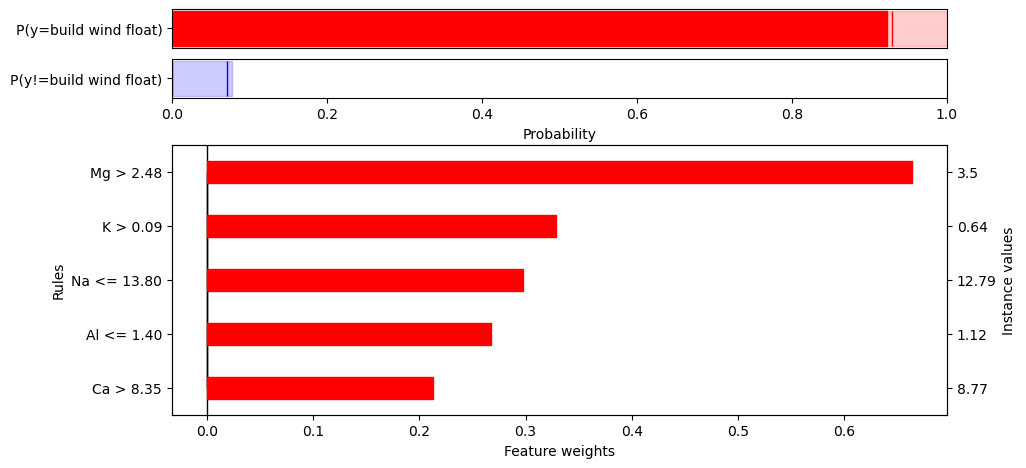

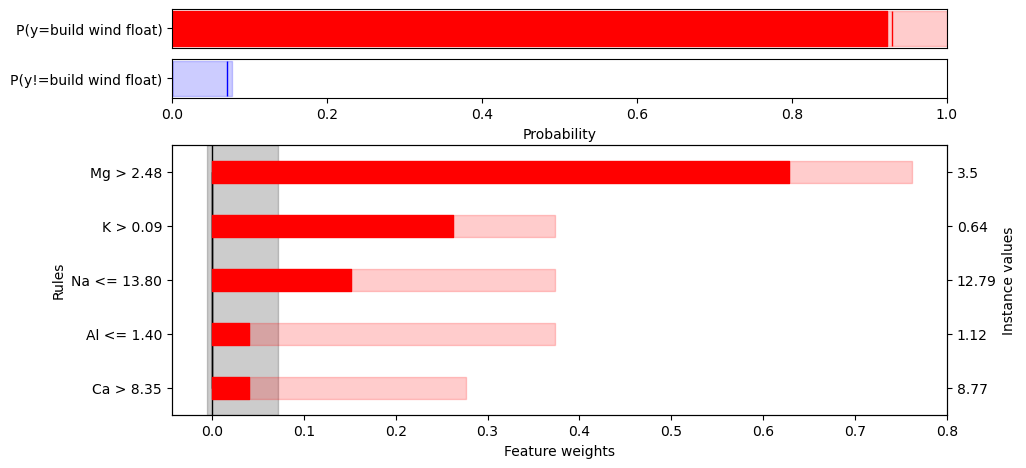

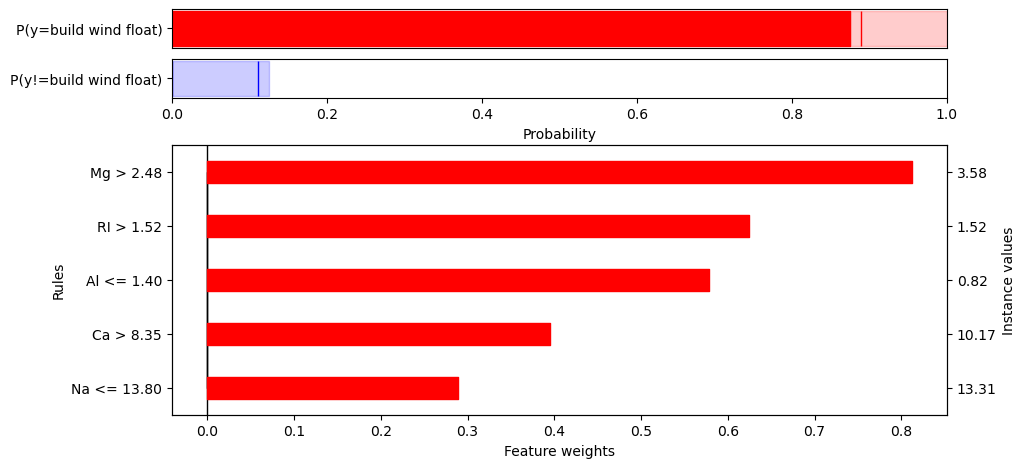

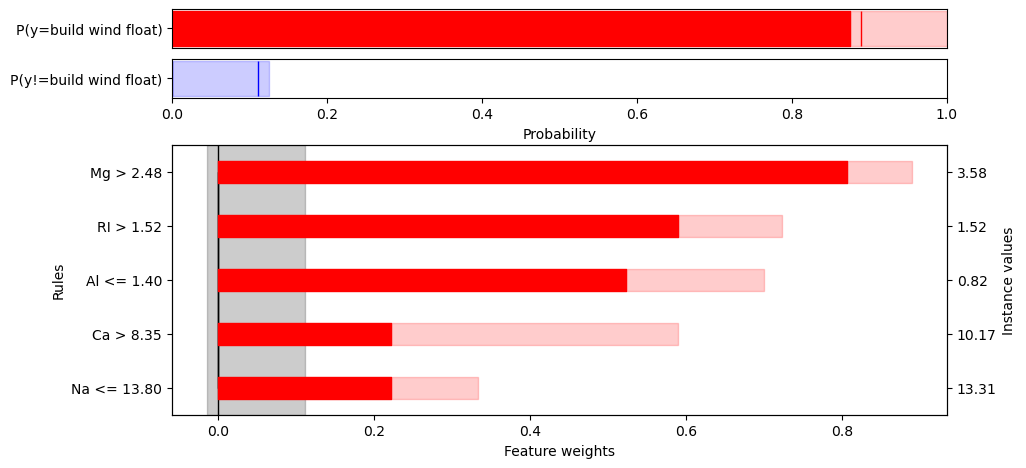

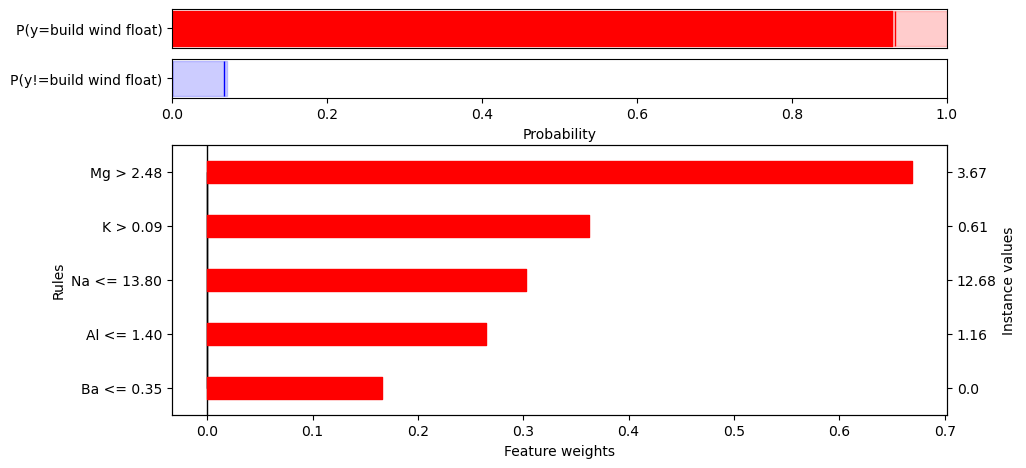

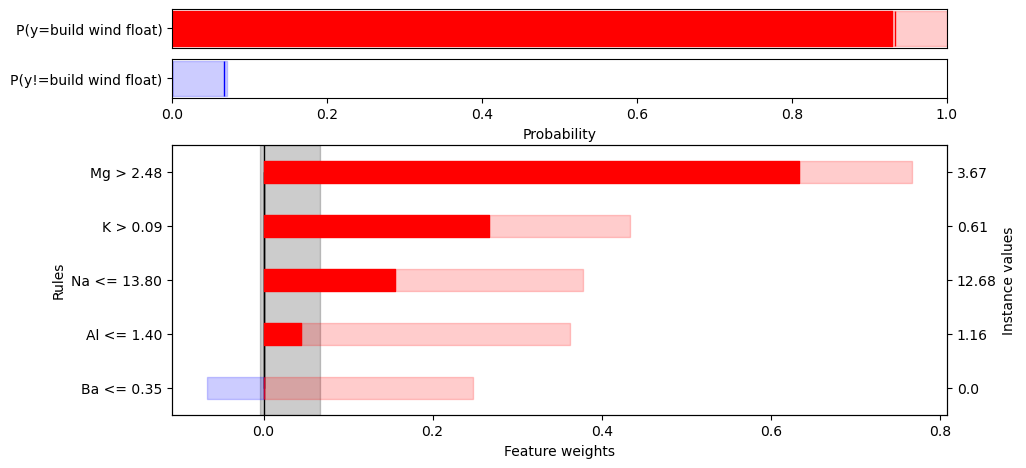

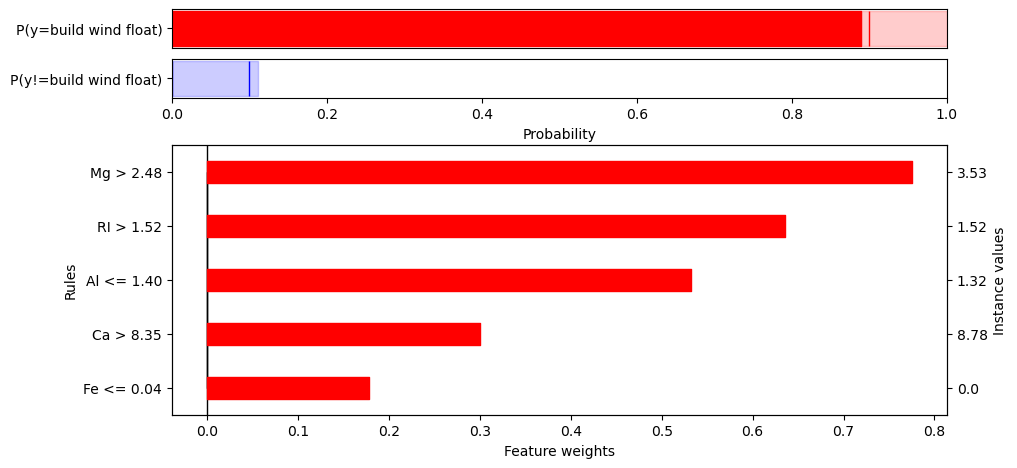

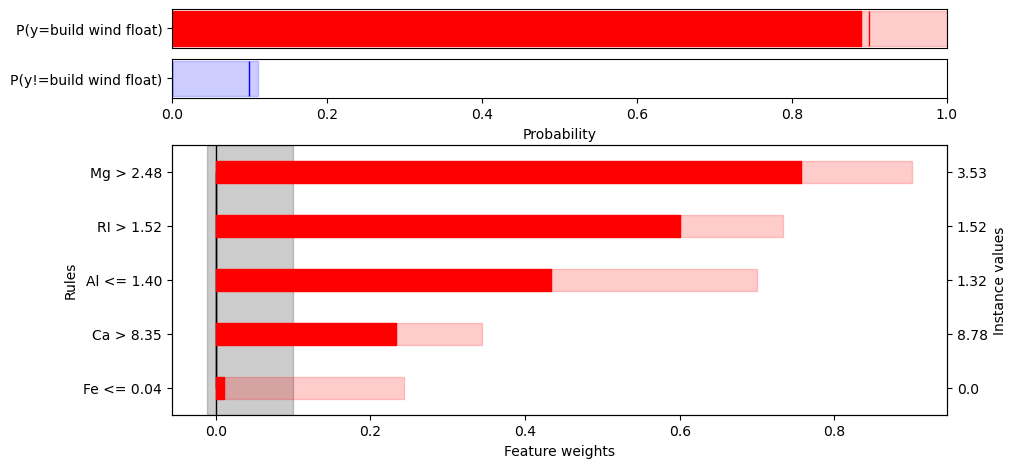

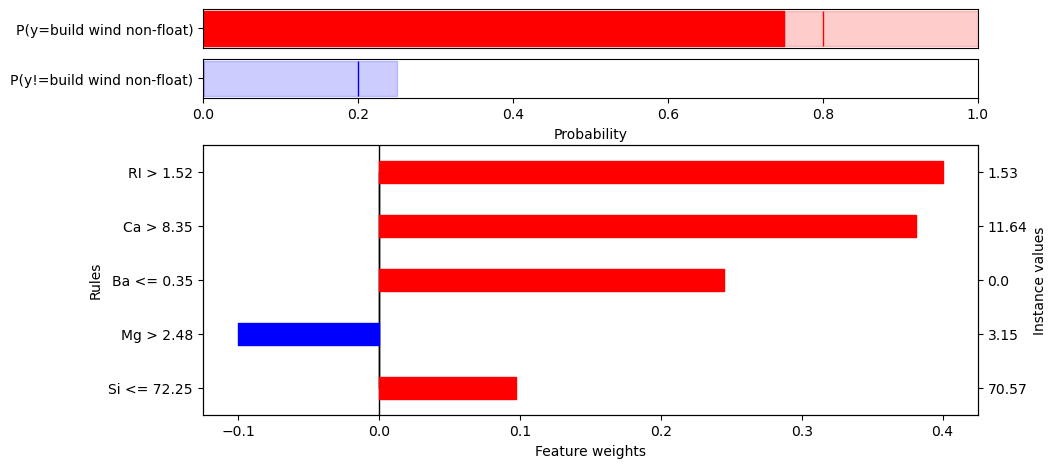

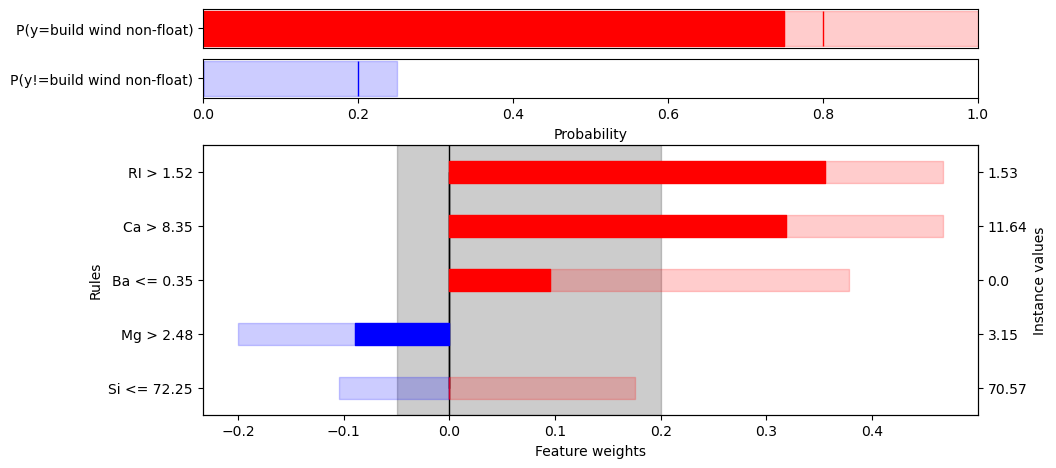

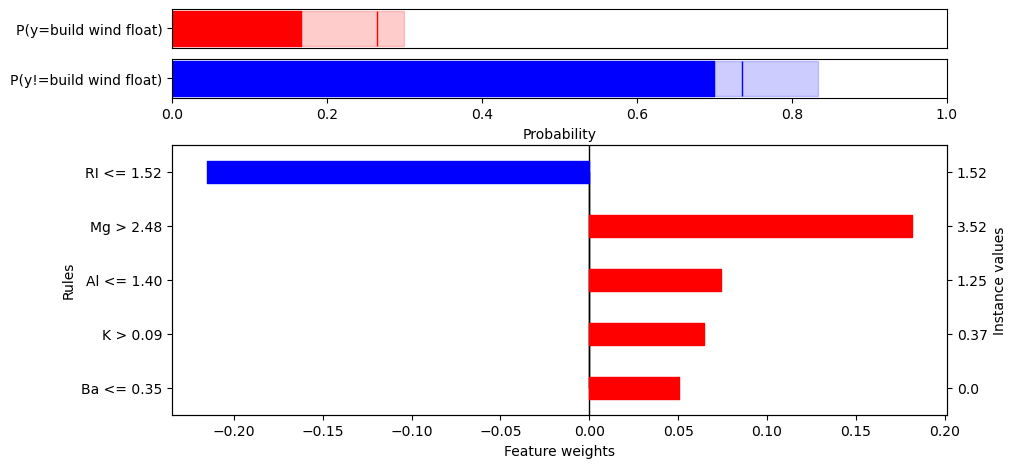

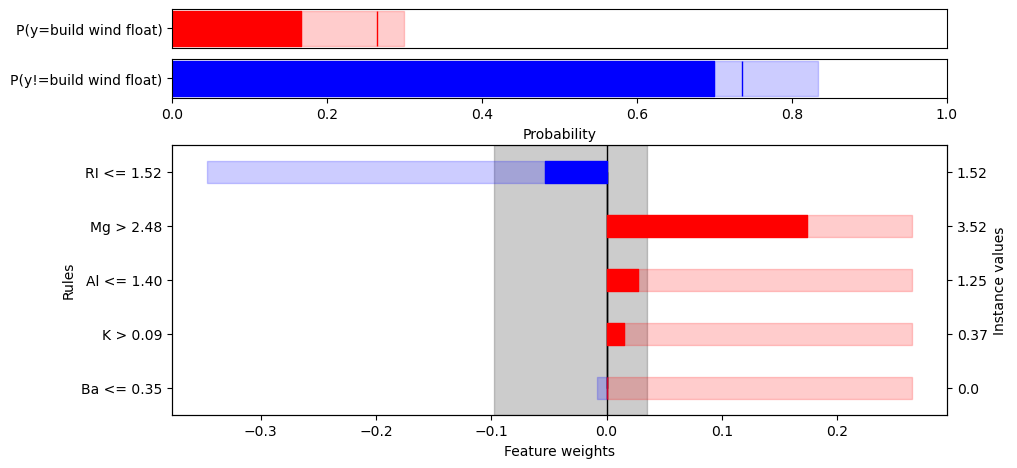

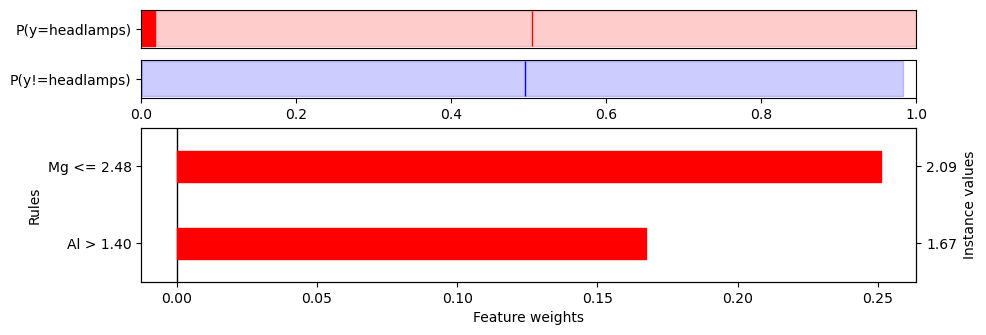

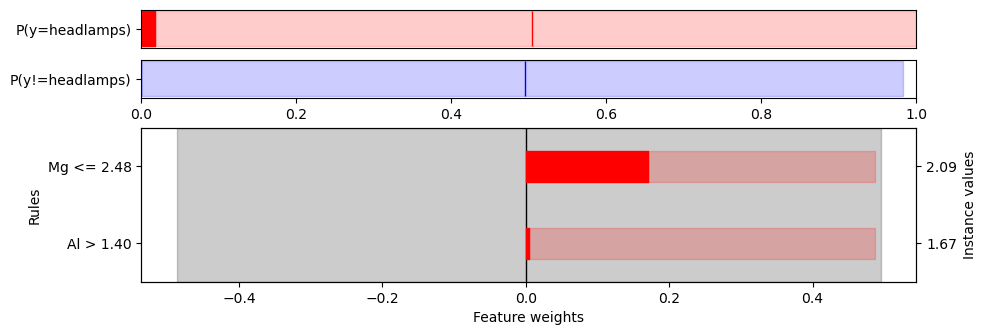

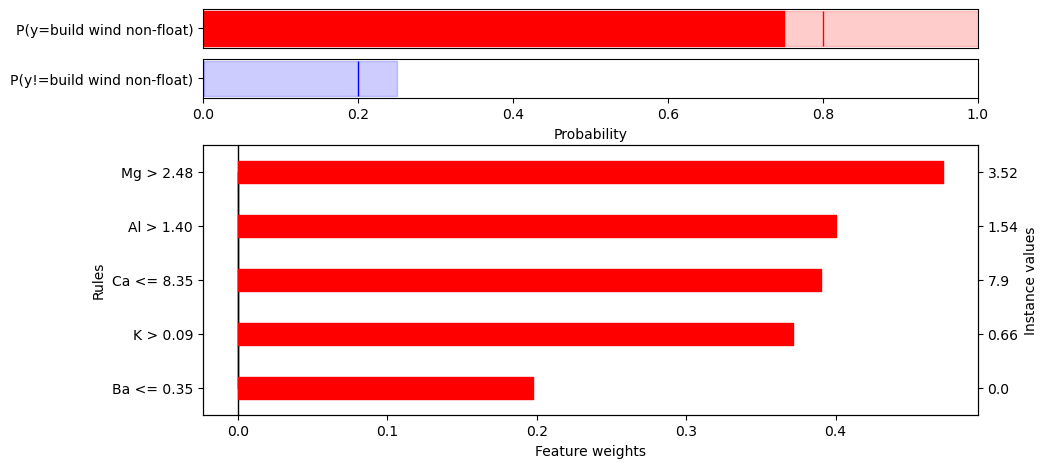

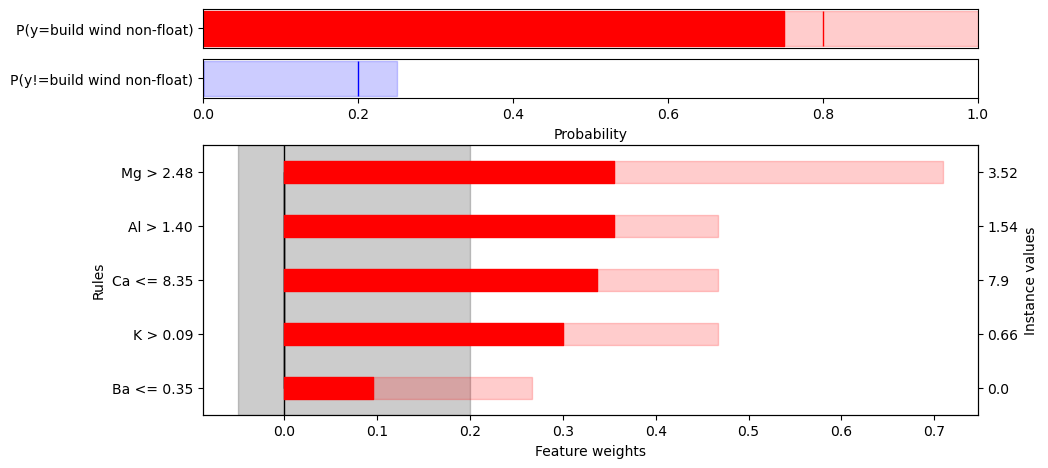

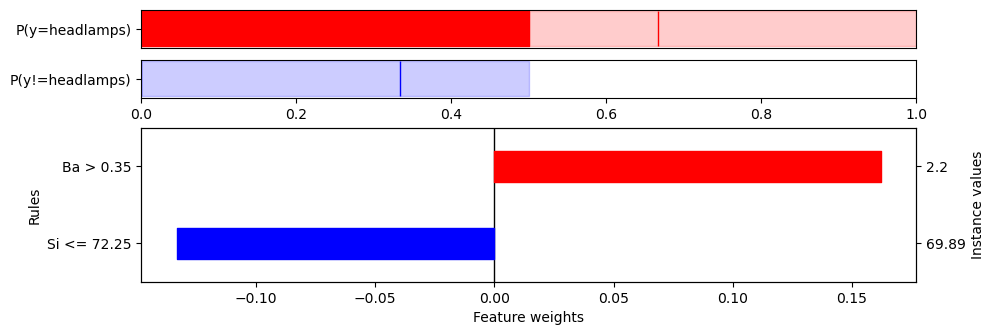

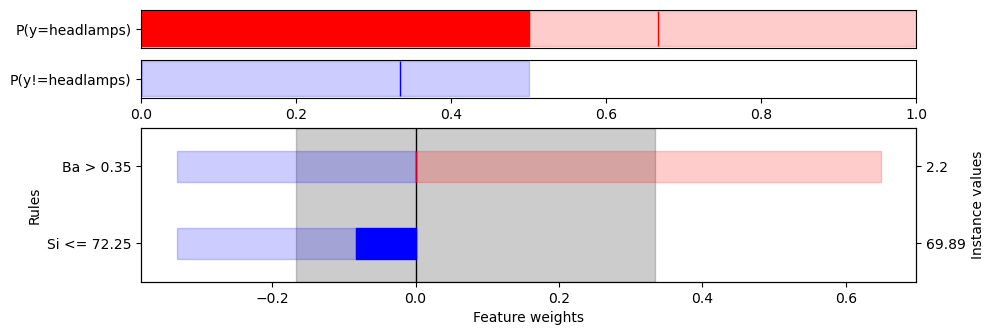

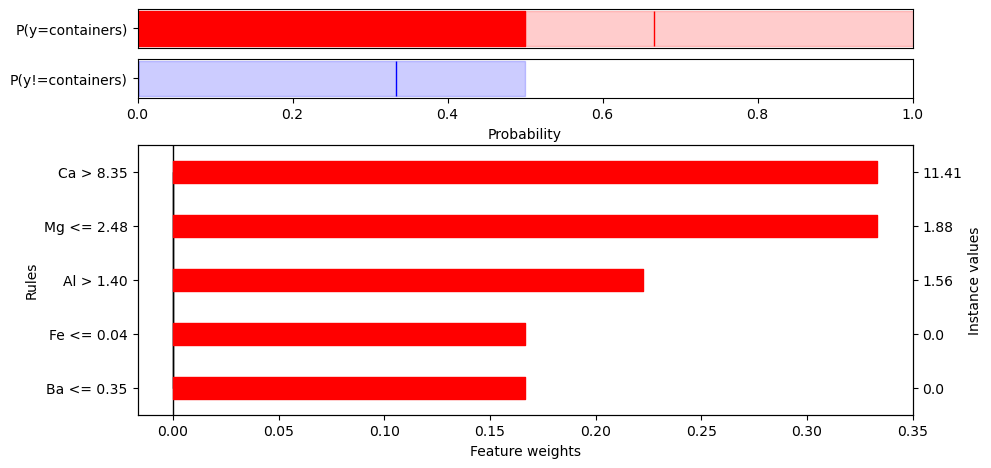

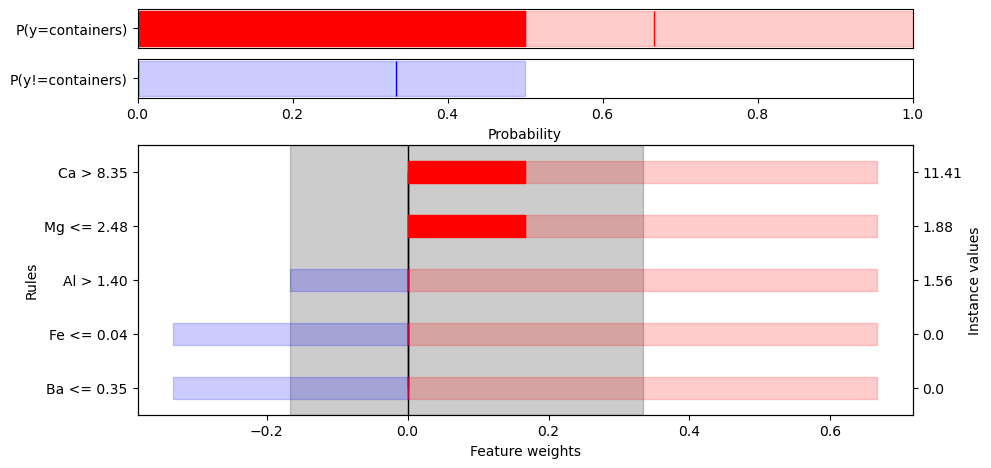

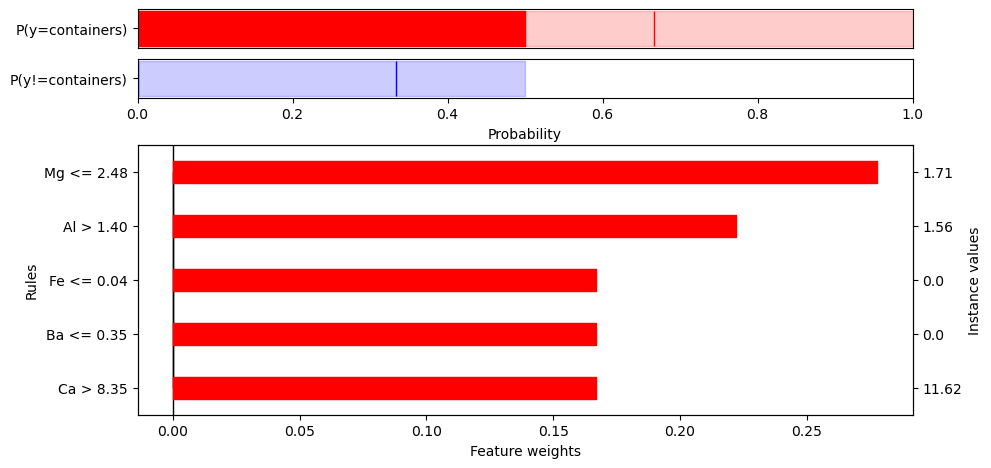

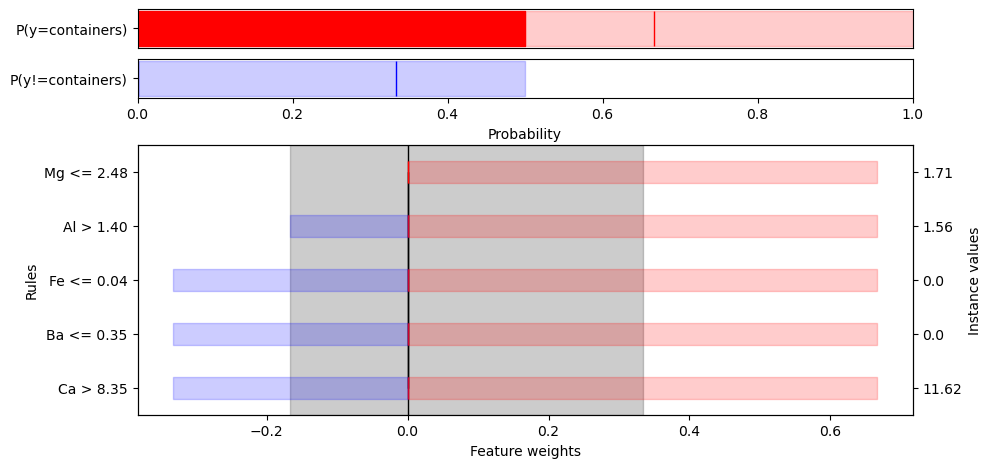

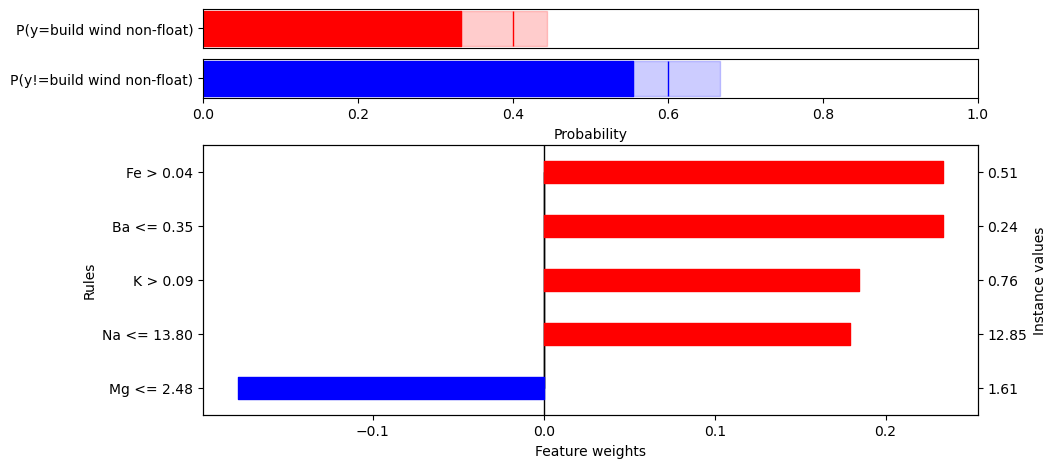

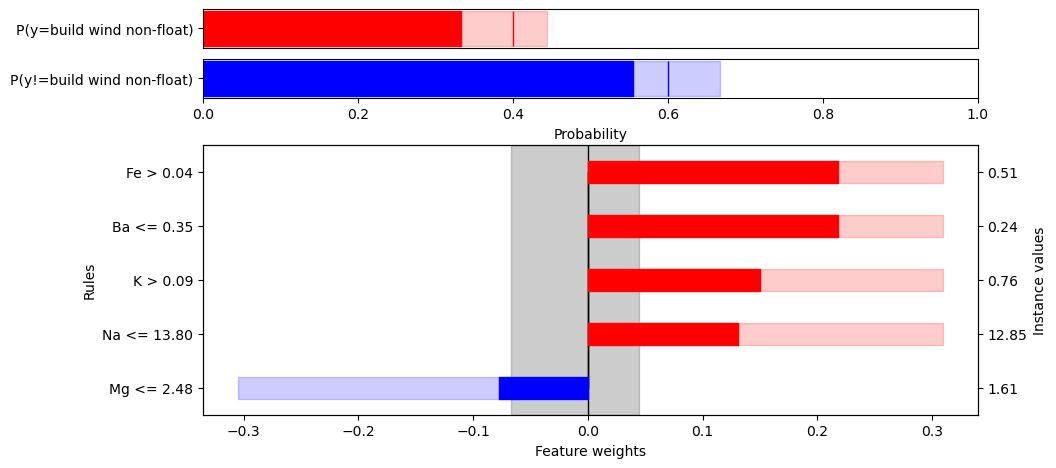

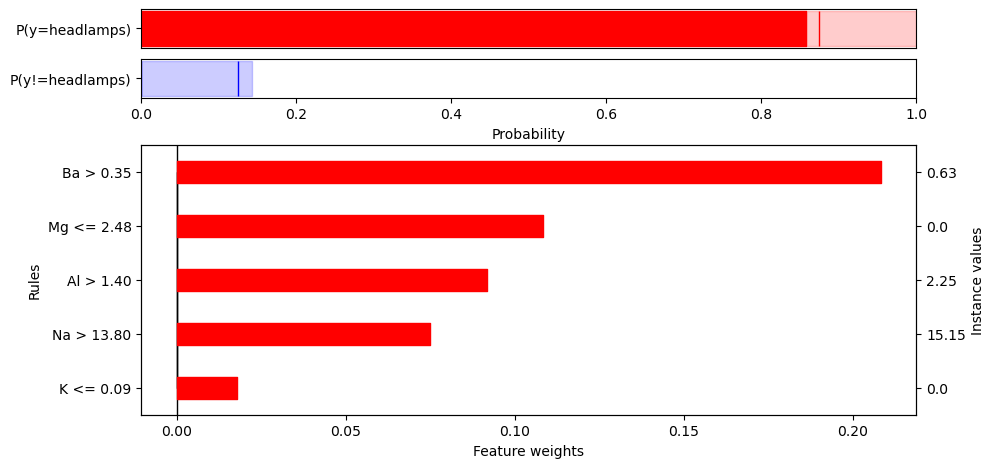

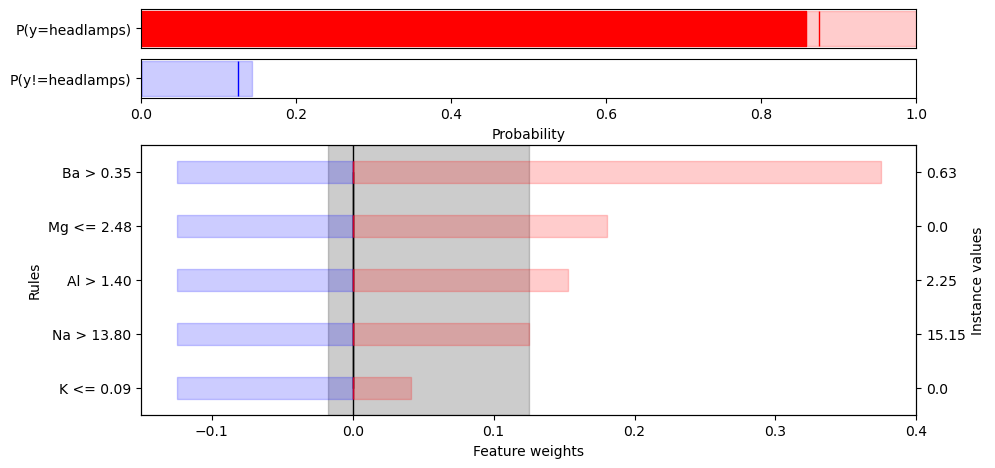

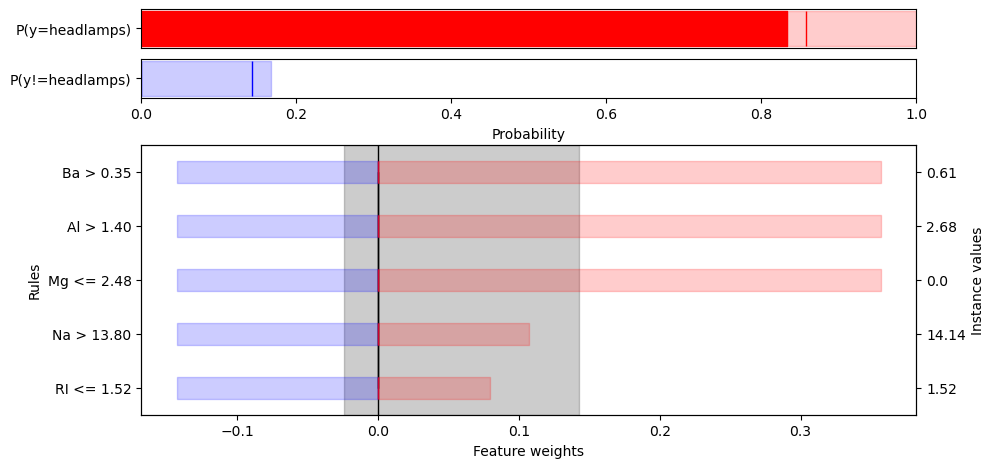

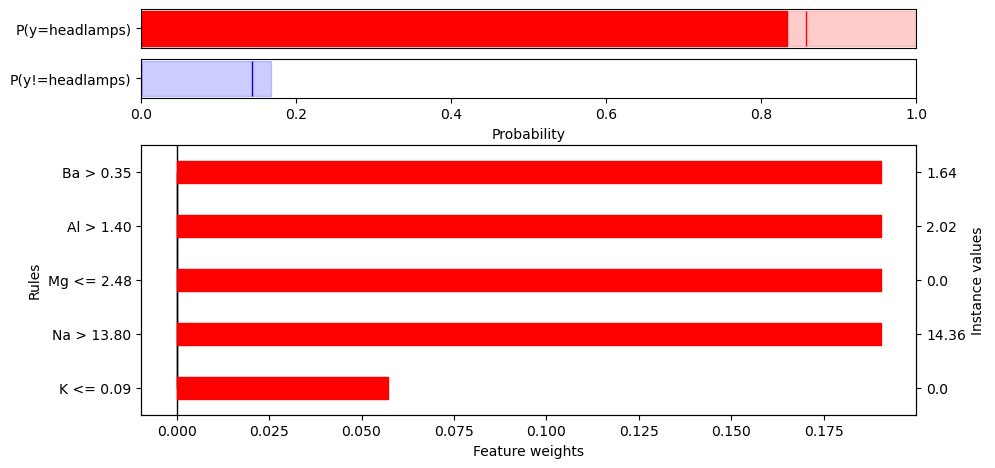

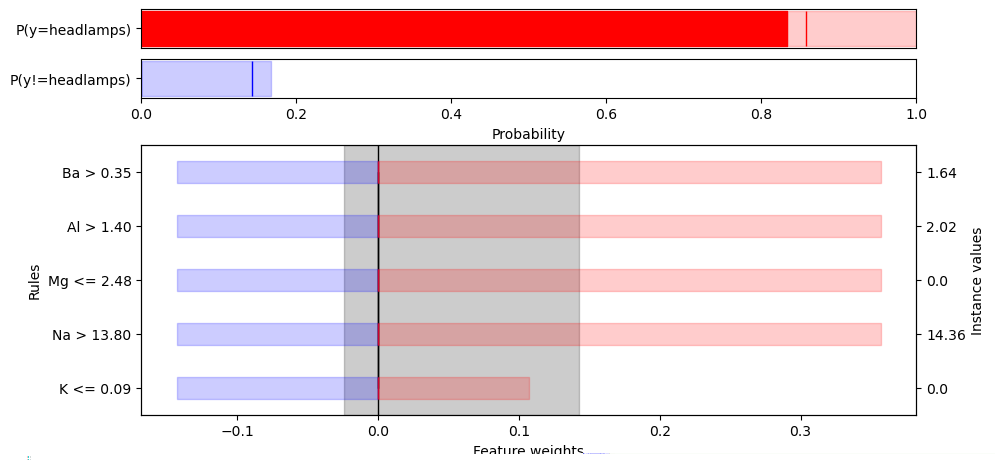

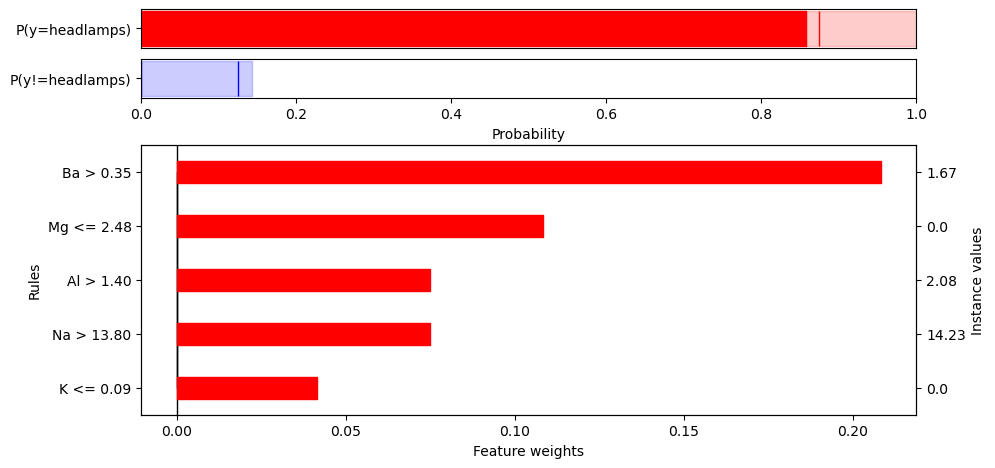

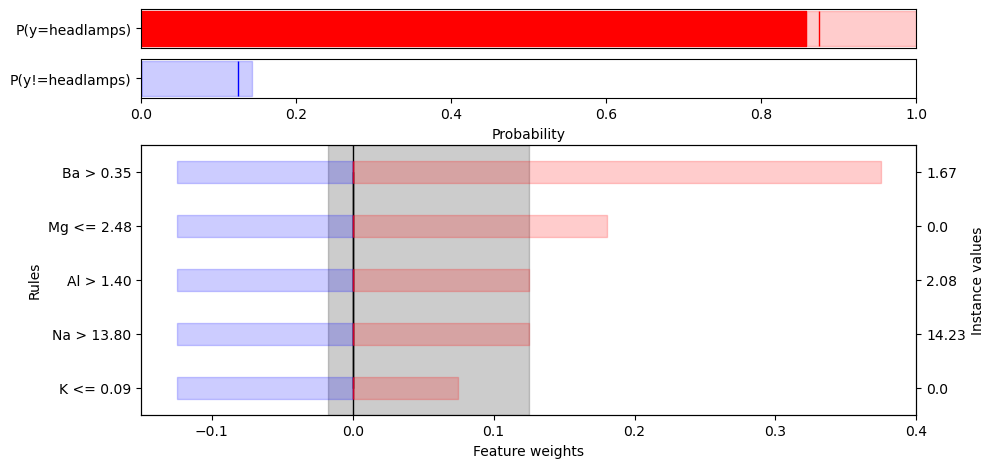

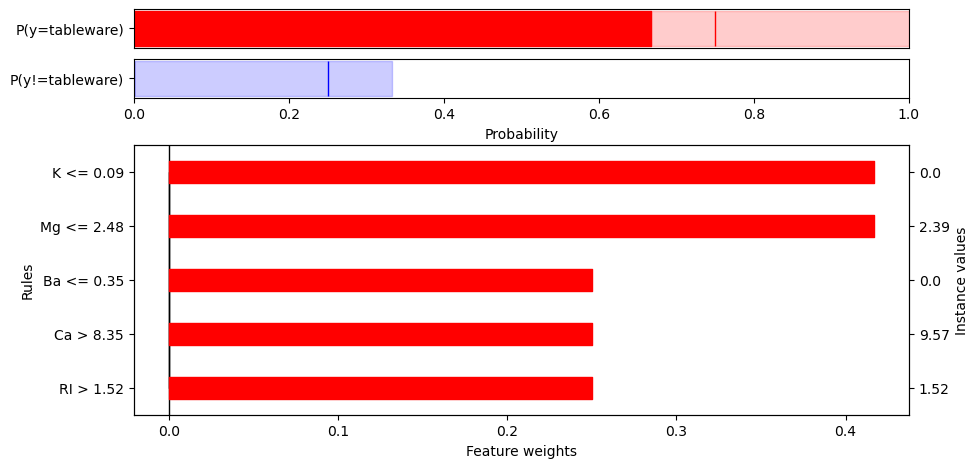

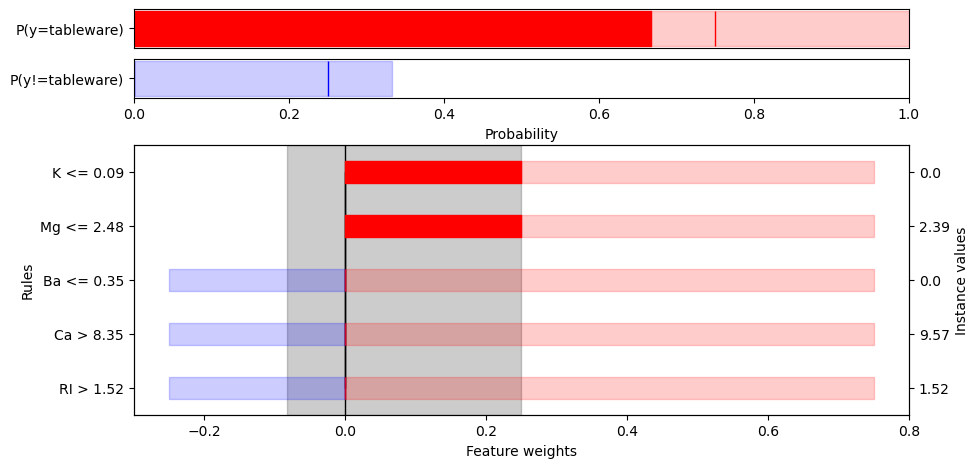

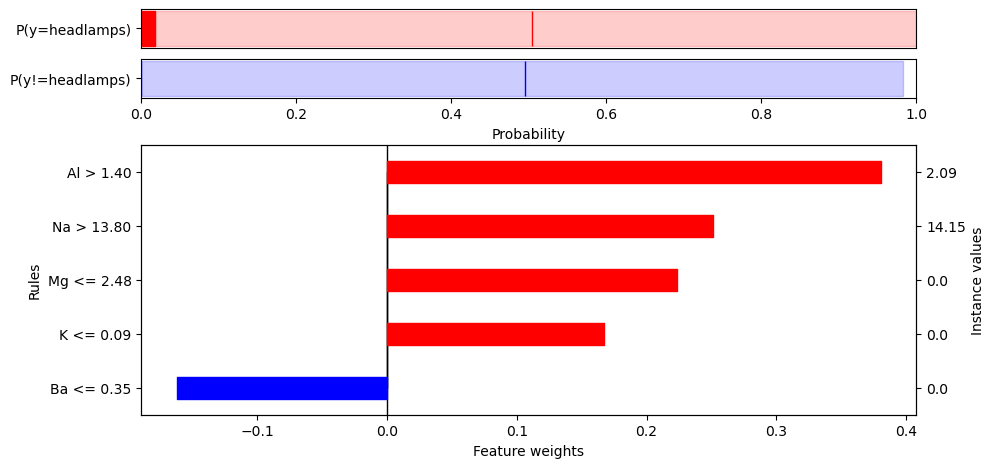

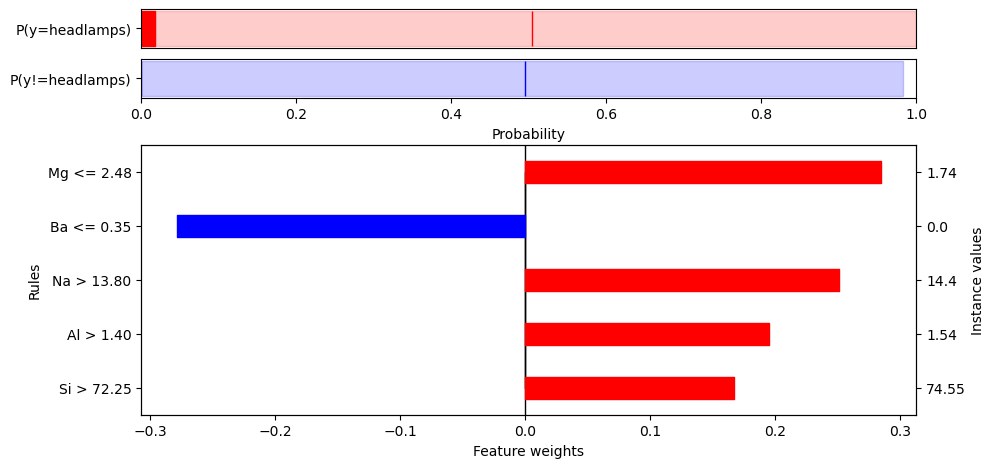

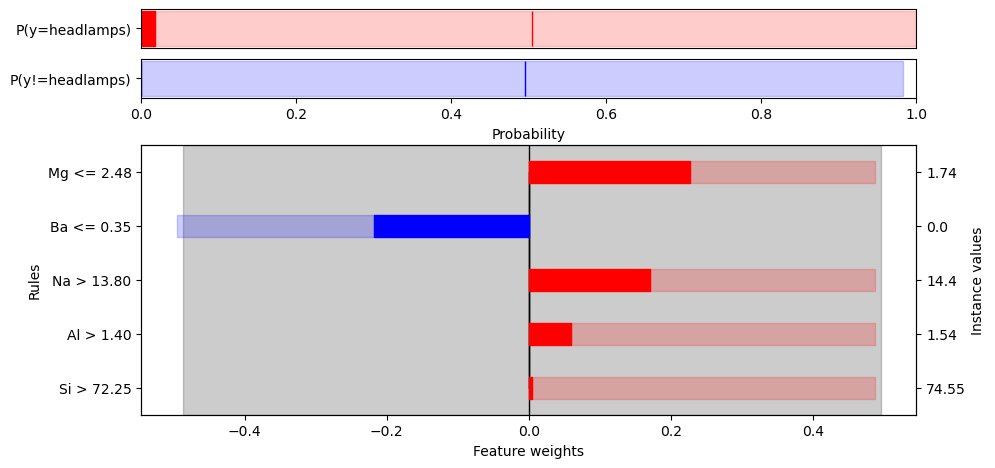

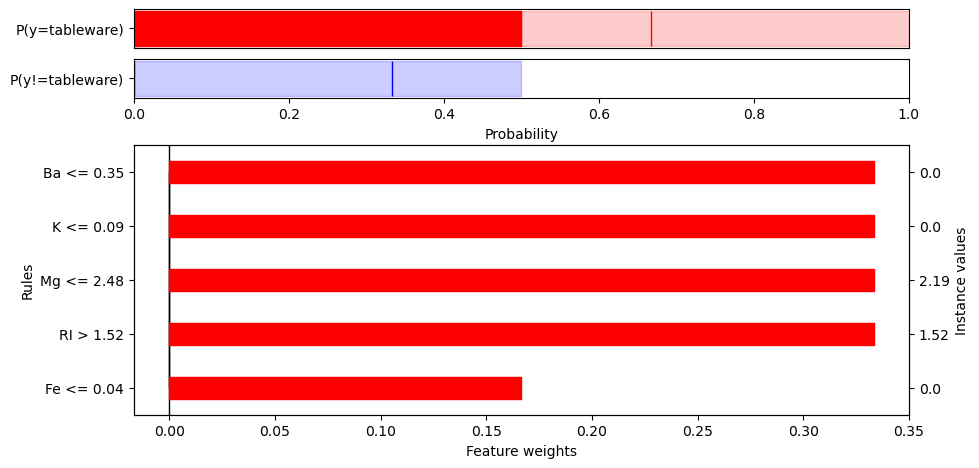

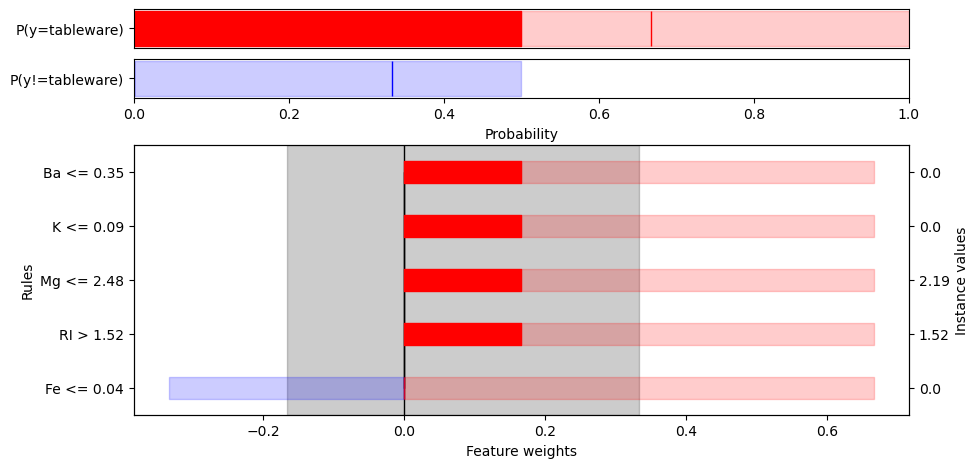

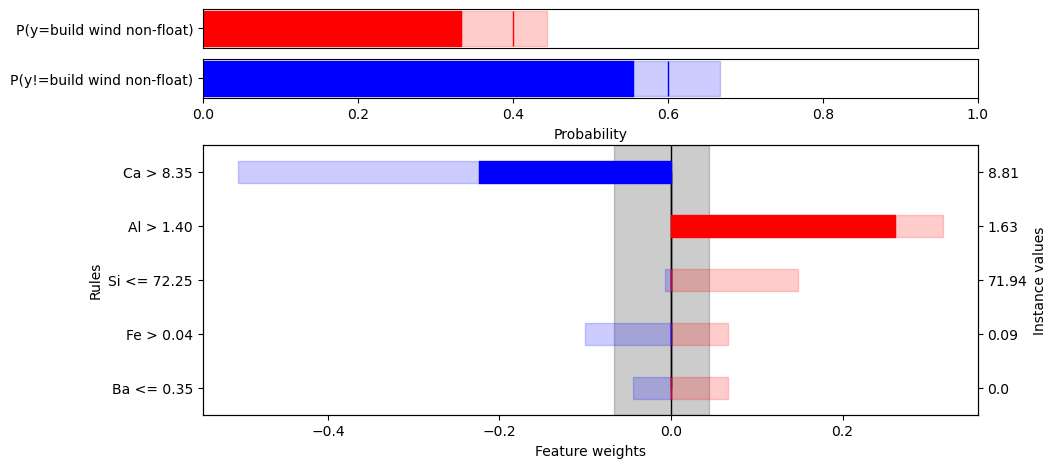

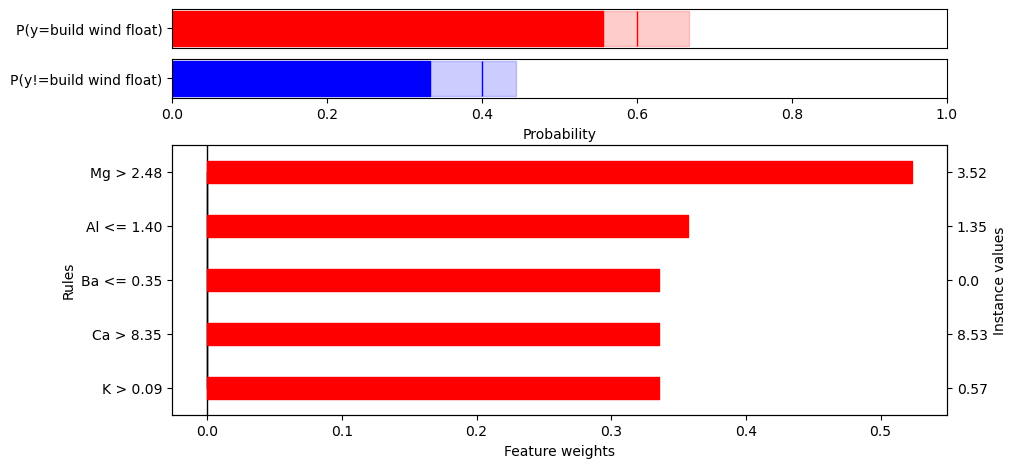

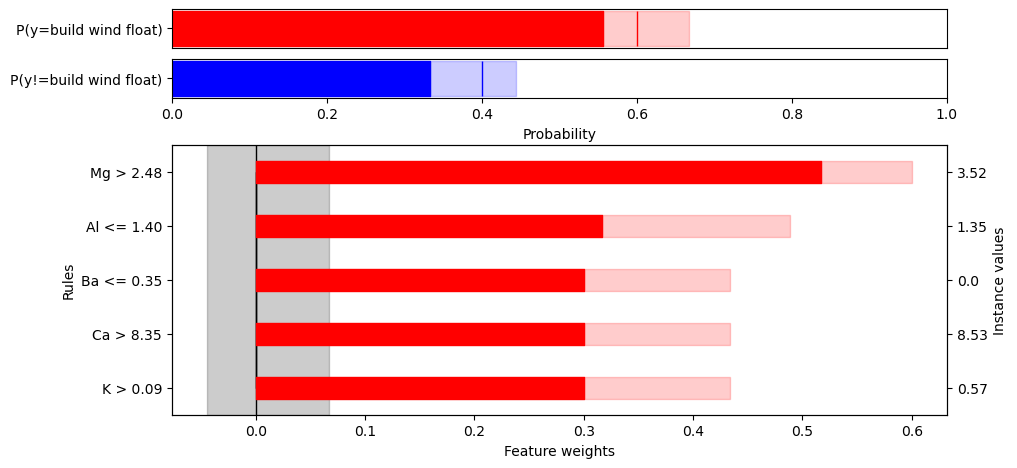

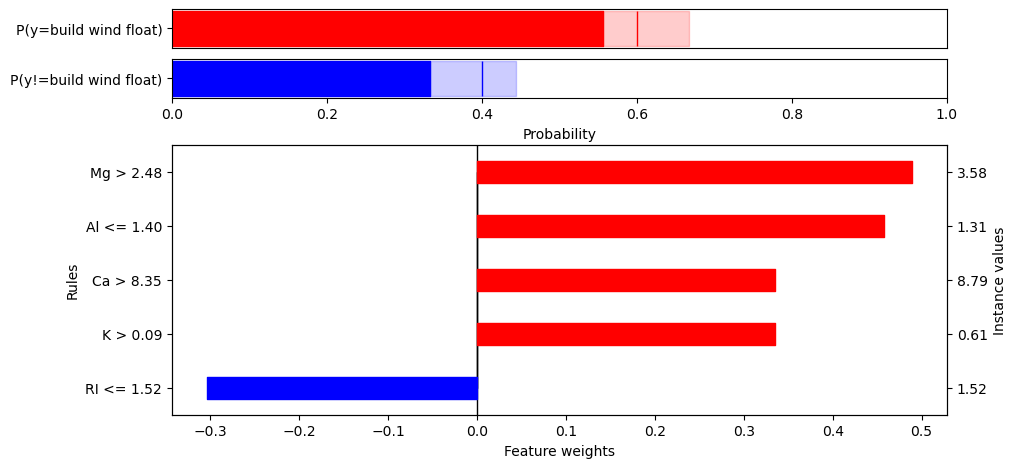

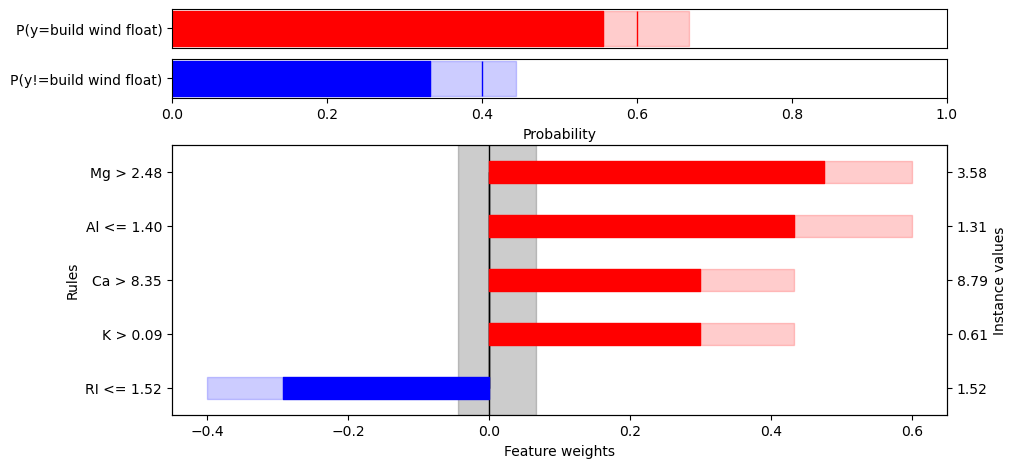

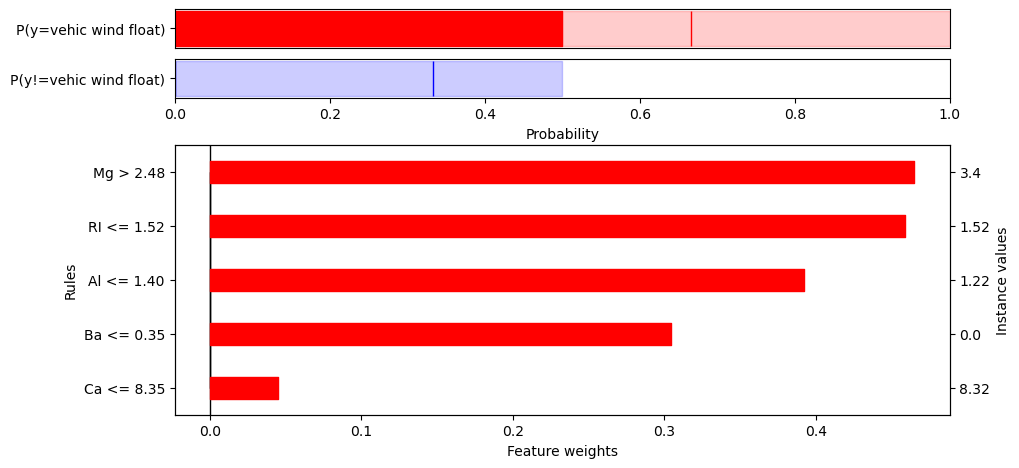

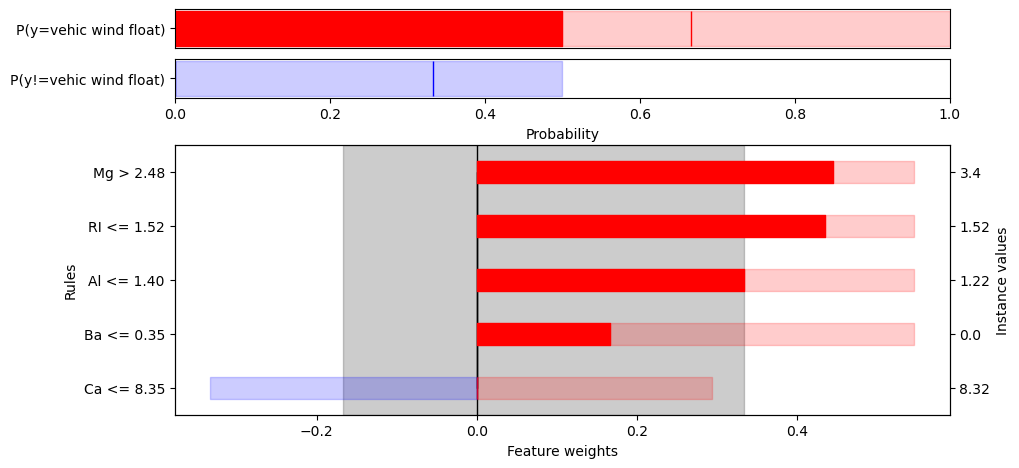

In [11]:
for i in range(num_to_test):
    explanation = factual_explanations.get_explanation(i)
    explanation.plot(n_features_to_show=5, filename=f'{dataSet}_{i}_c{y_test[i]}_p{predicted_classes[i]}_simple_factual.png')
    explanation.plot(uncertainty=True, n_features_to_show=5, filename=f'{dataSet}_{i}_c{y_test[i]}_p{predicted_classes[i]}_simple_factual_uncertainty.png')

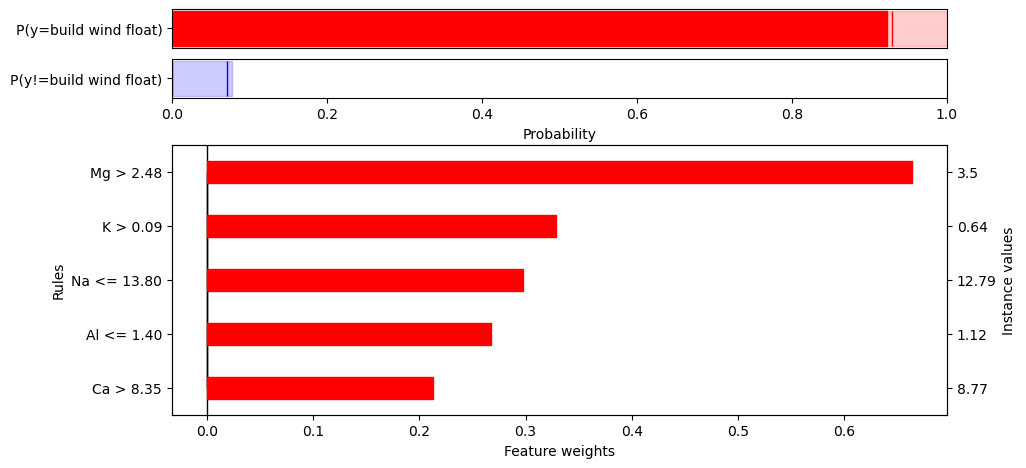

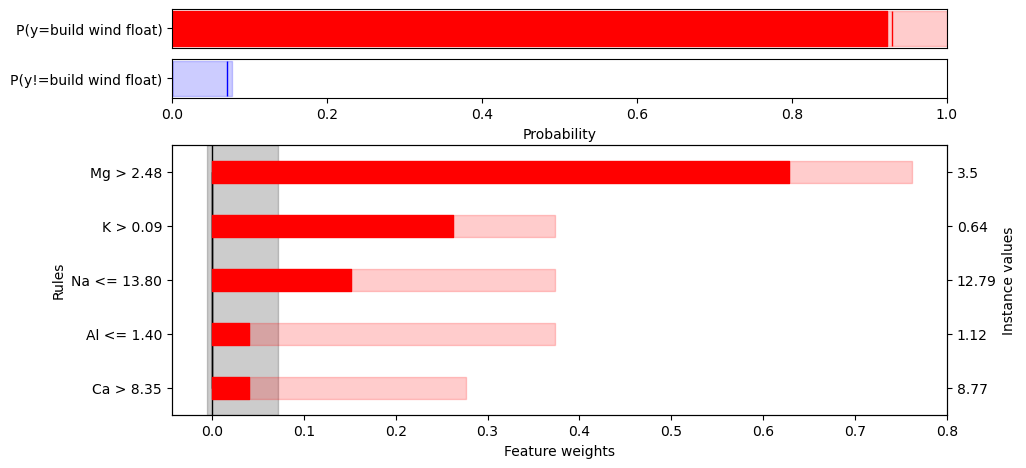

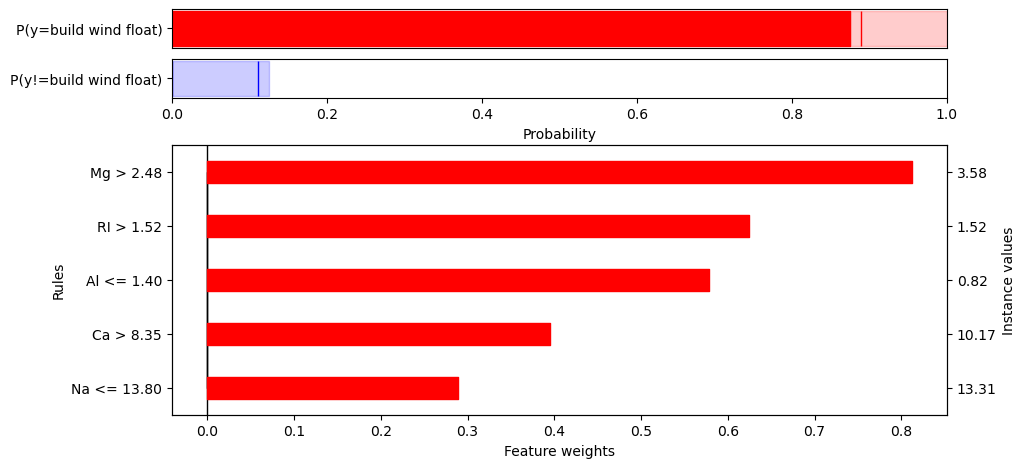

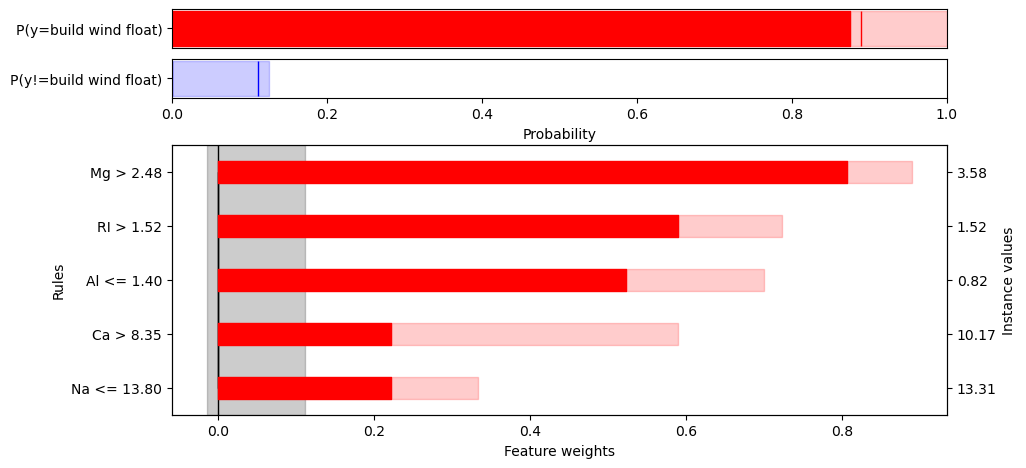

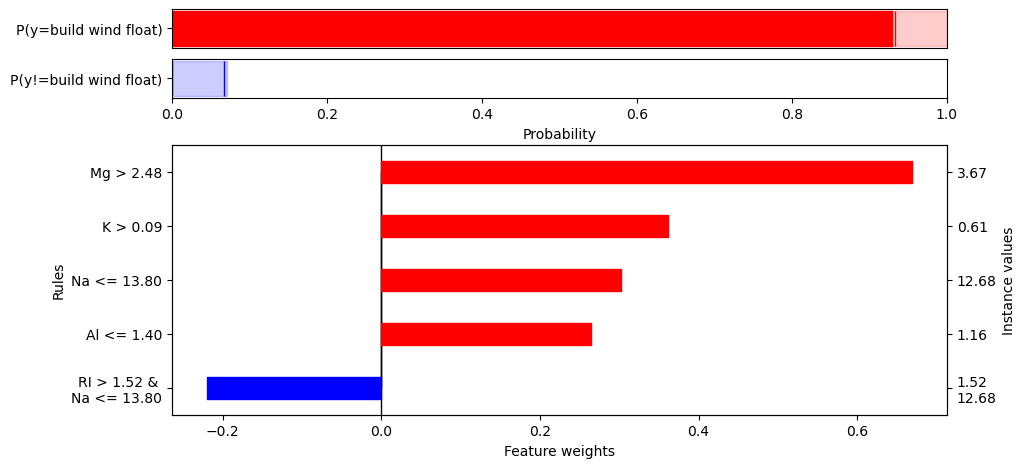

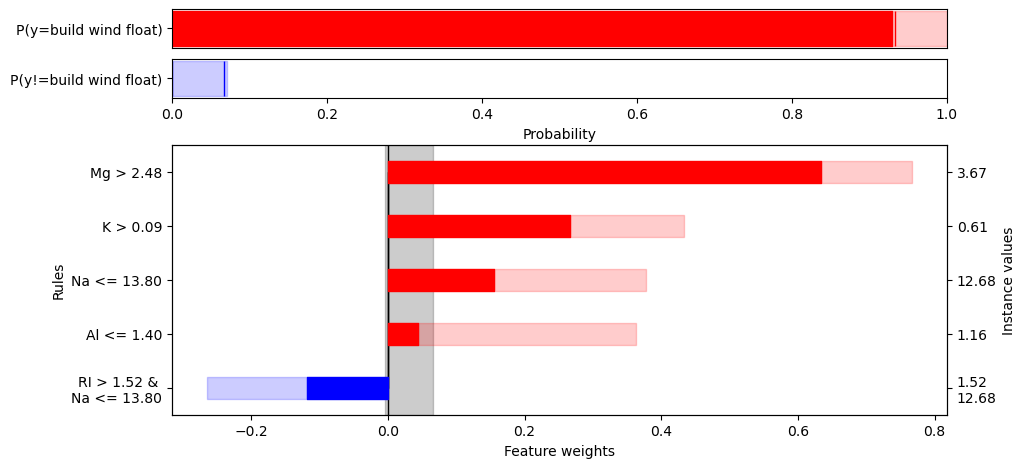

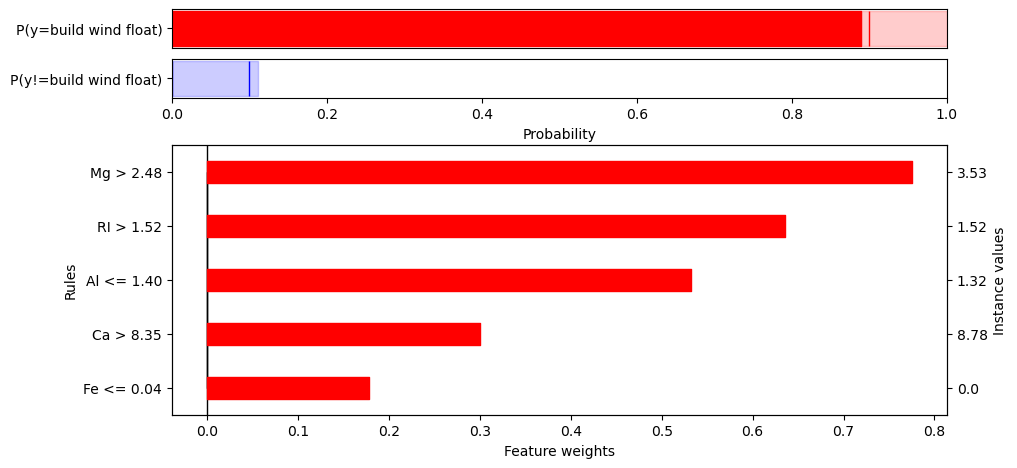

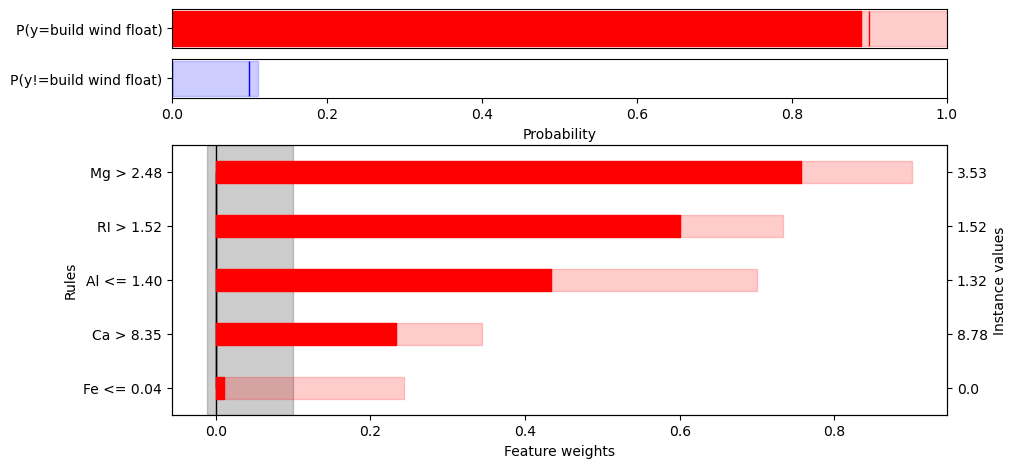

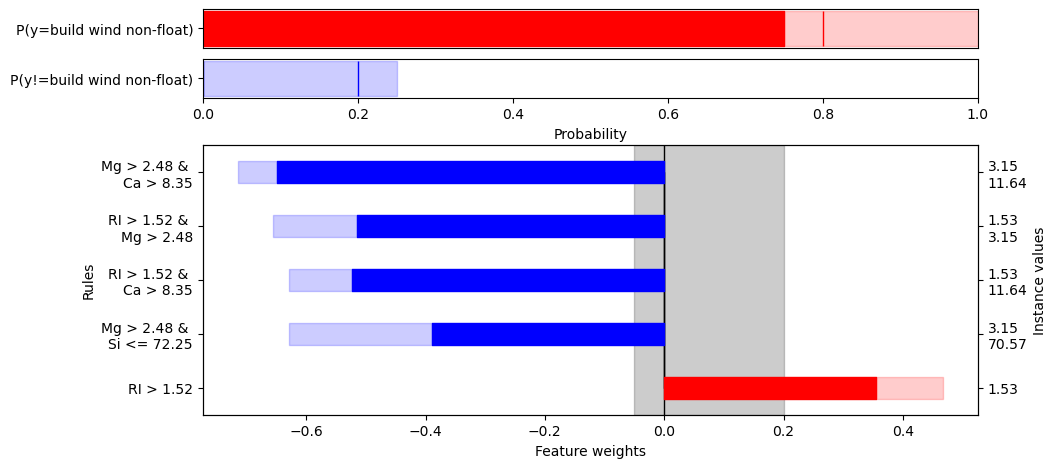

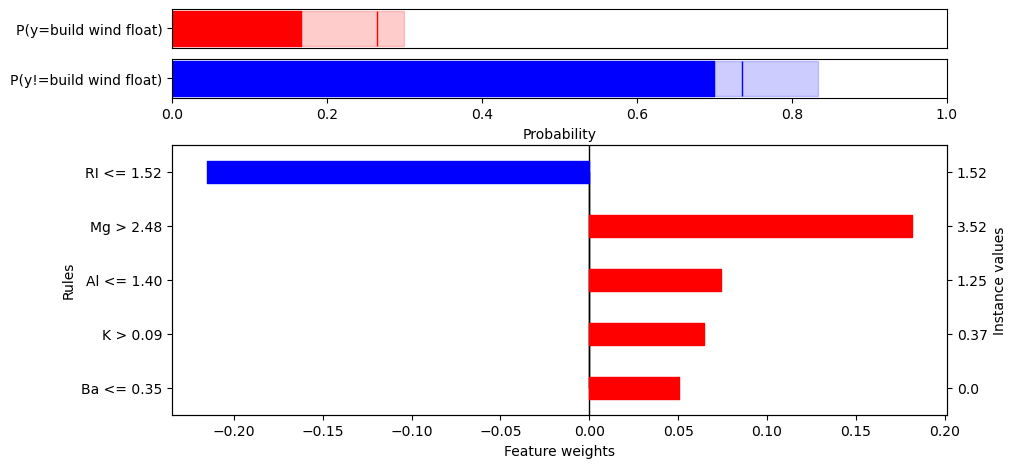

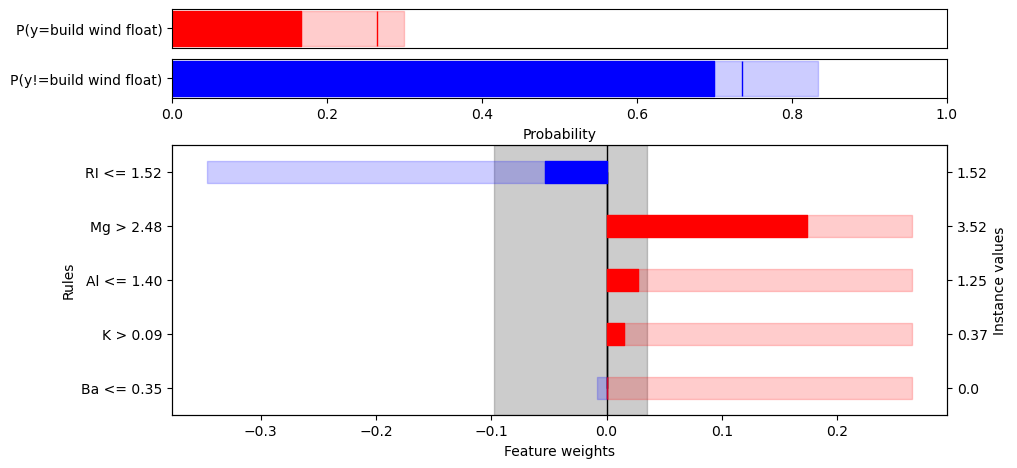

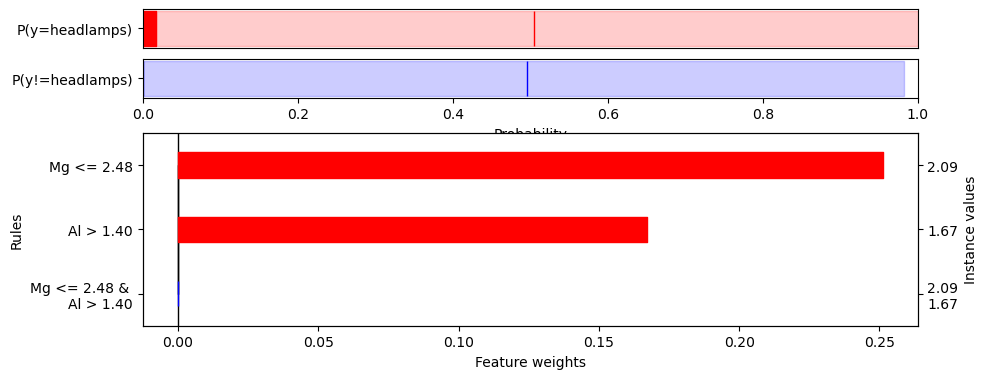

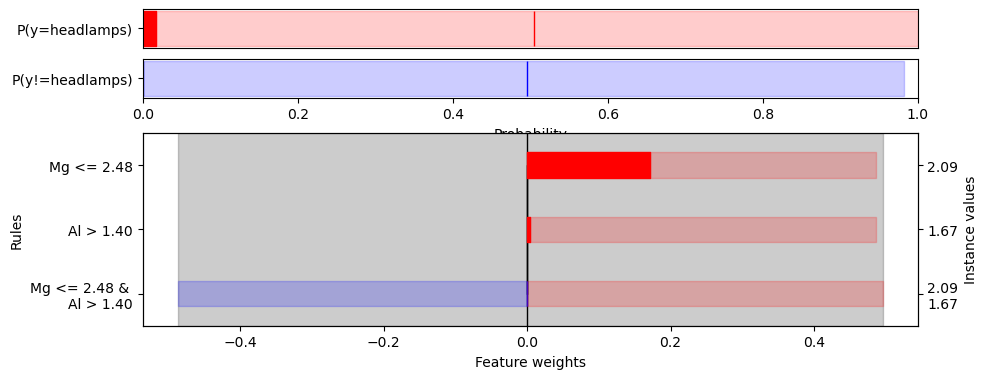

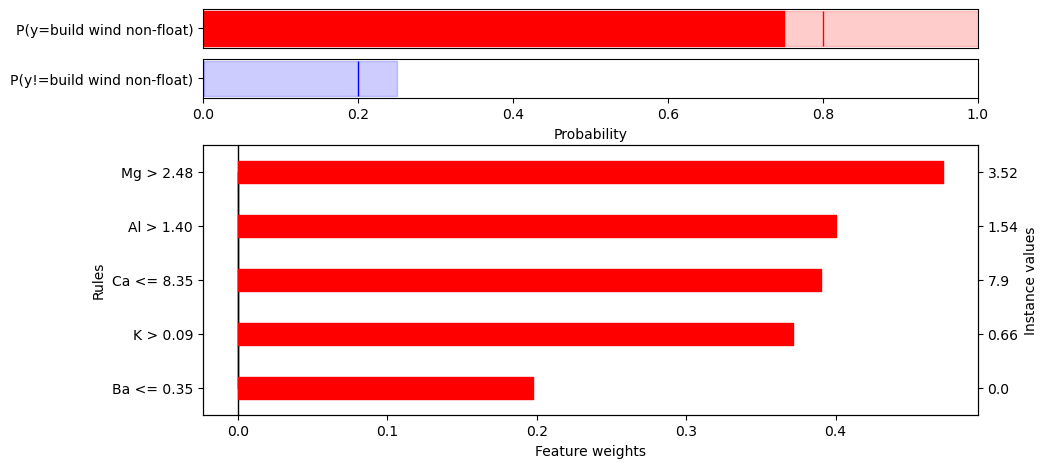

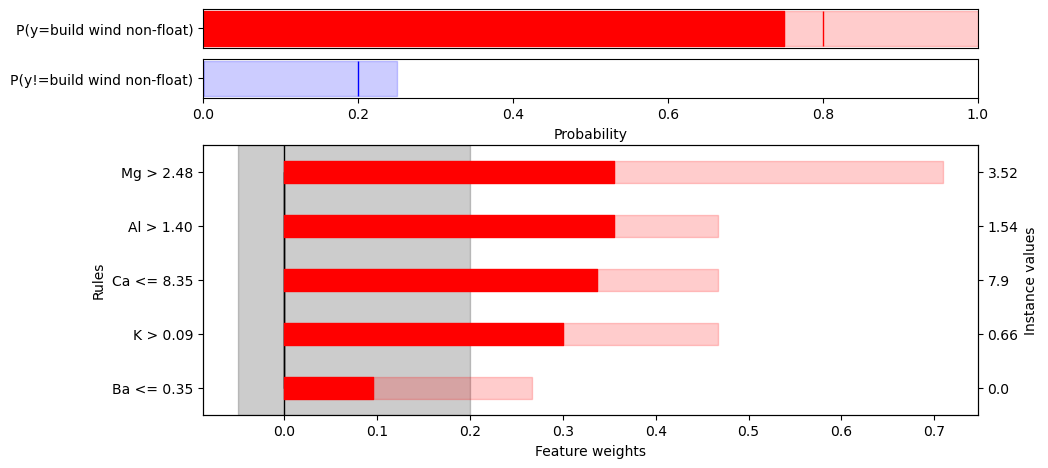

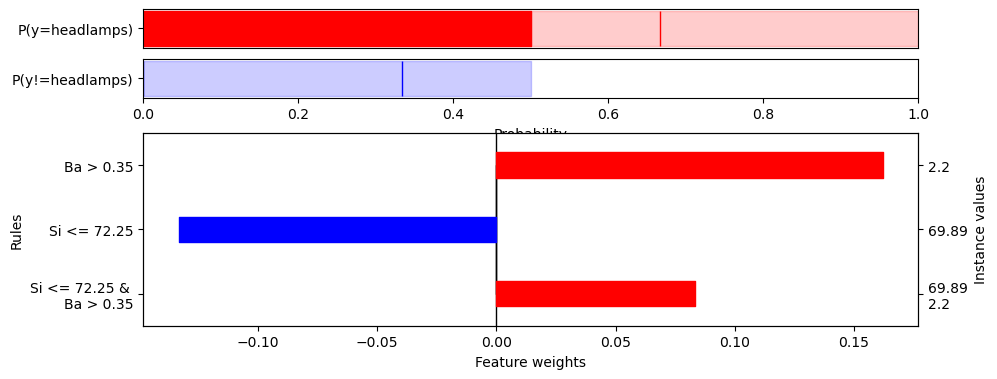

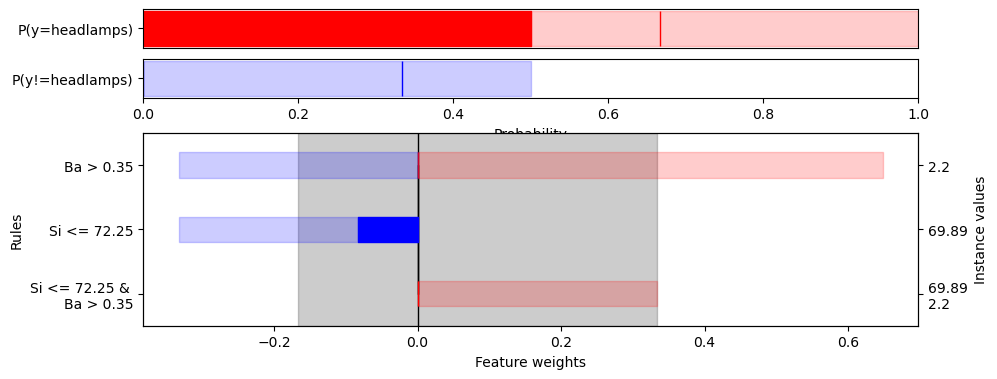

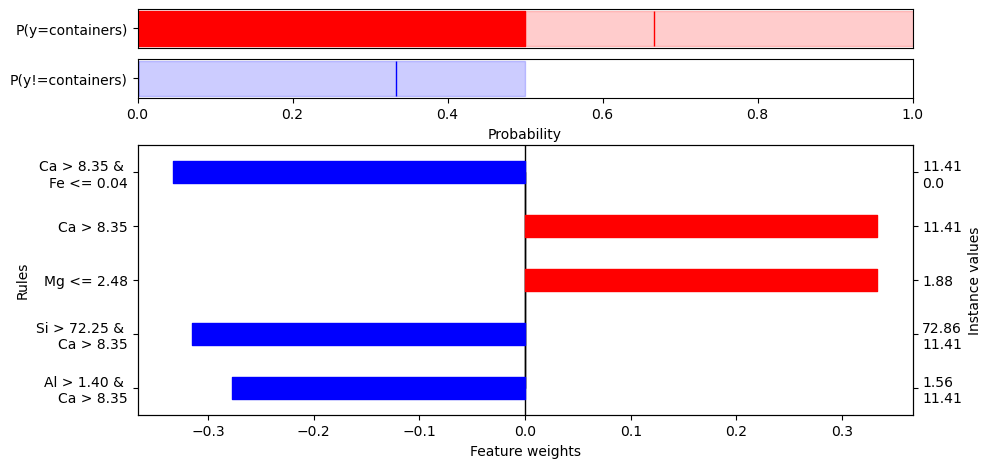

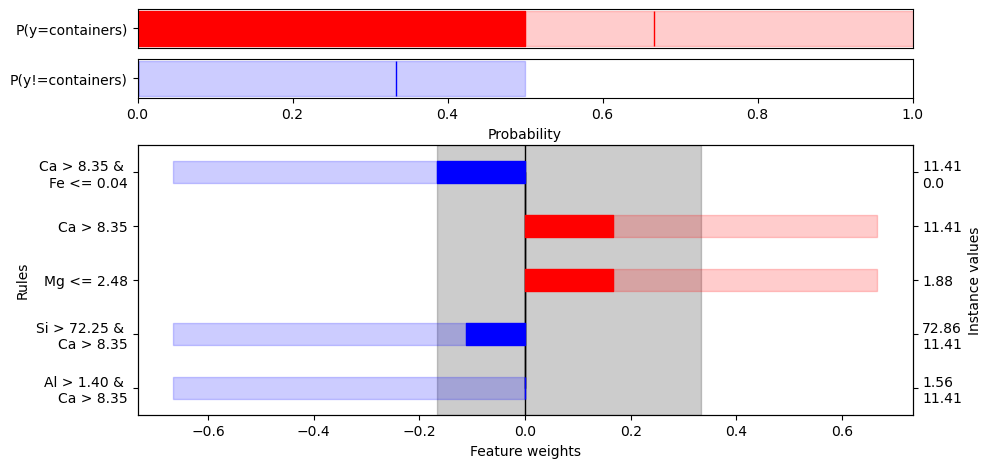

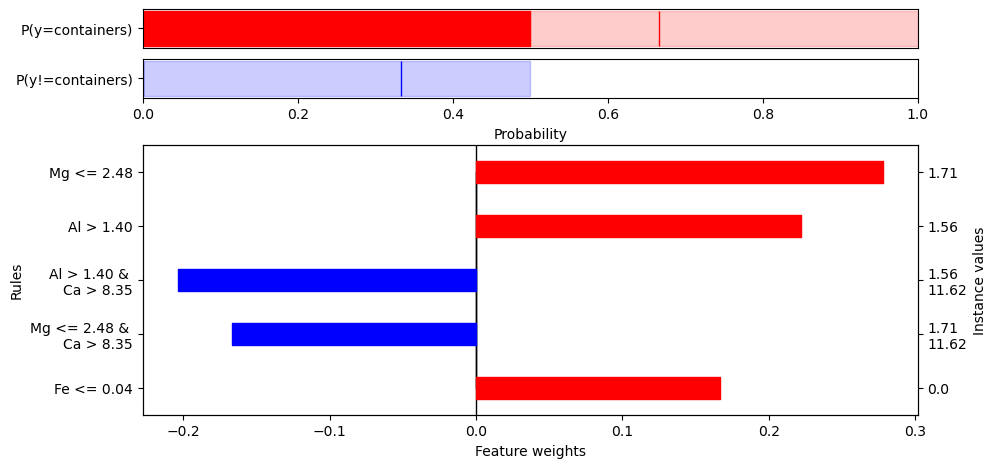

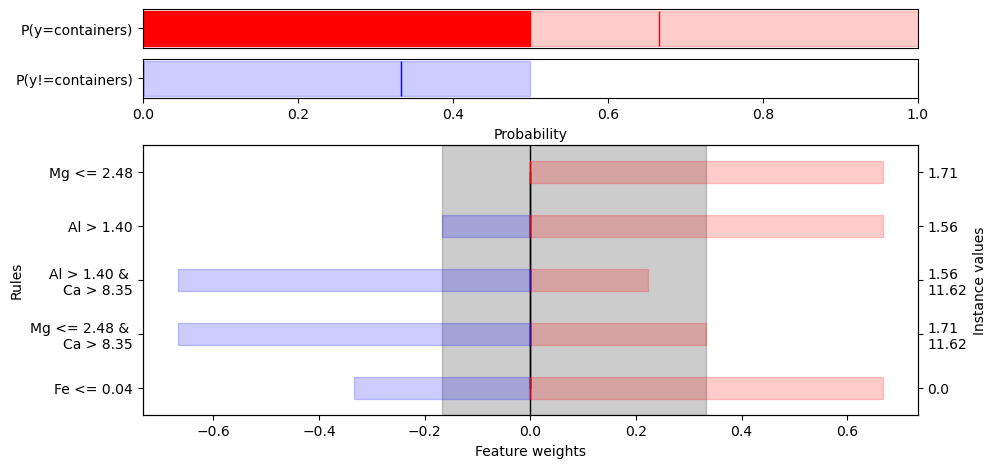

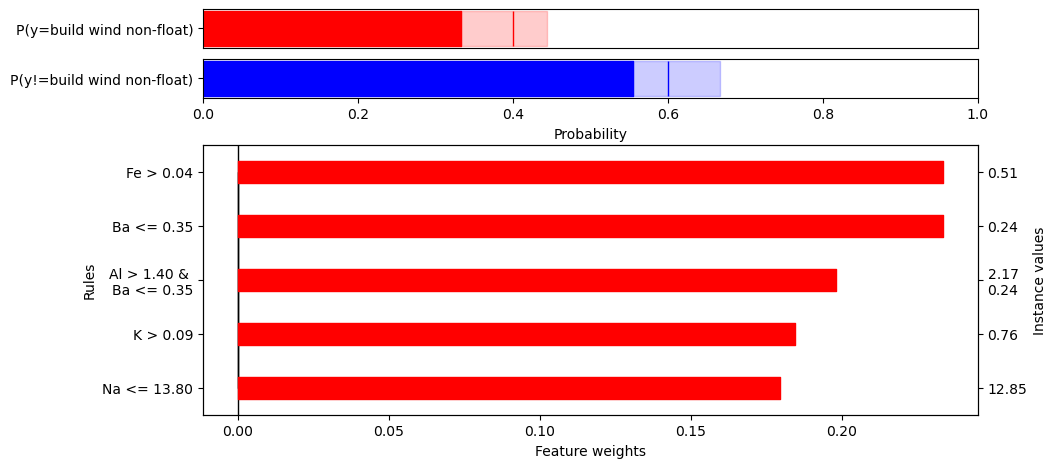

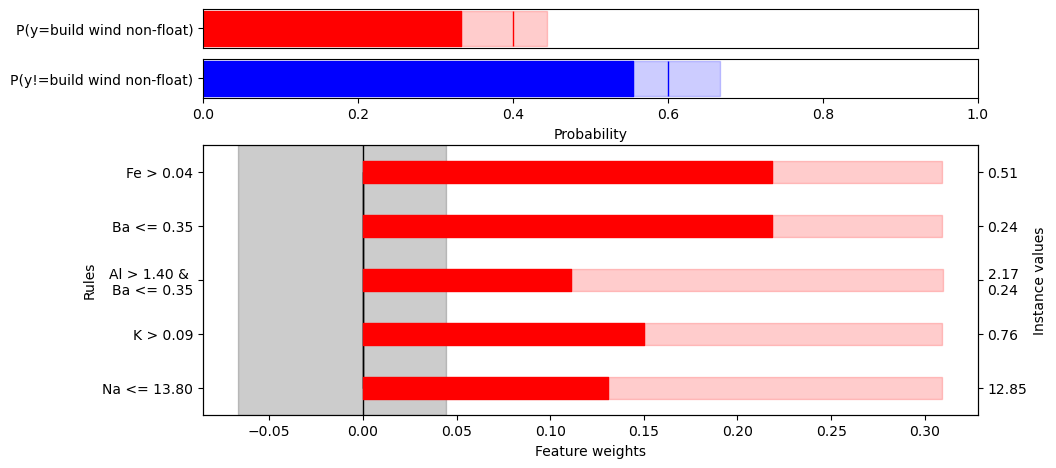

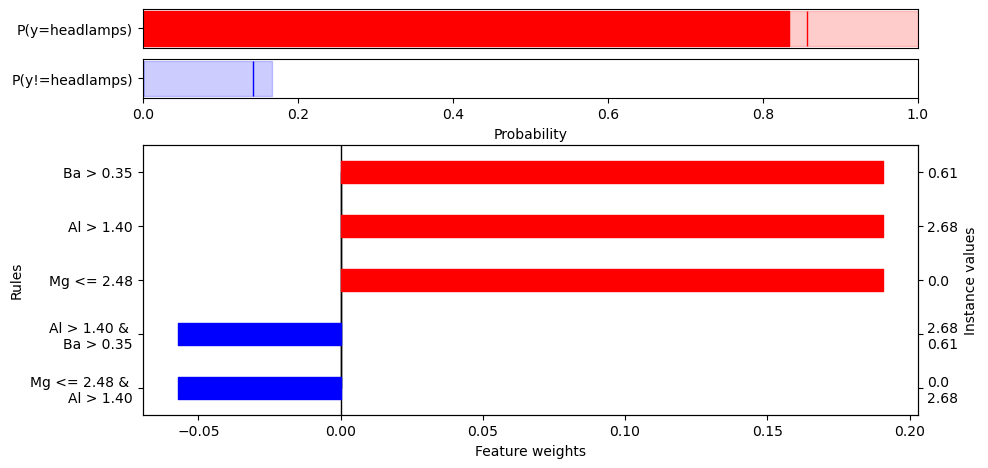

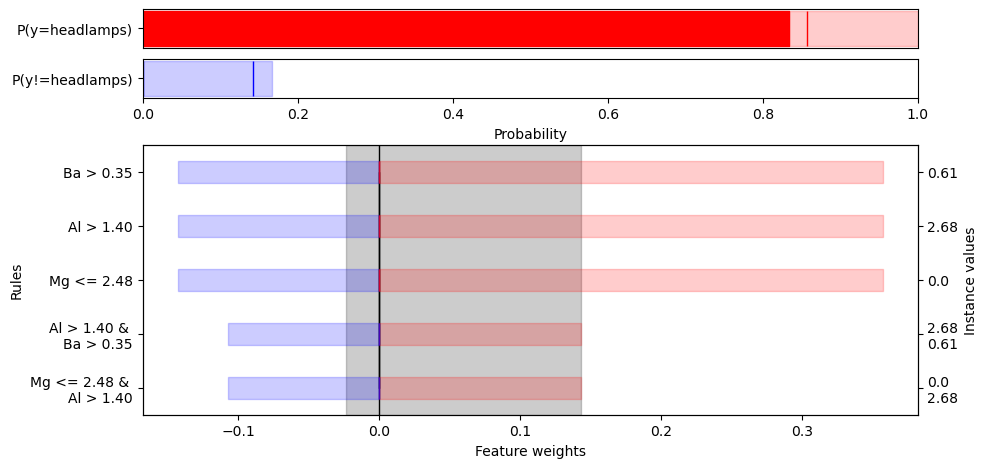

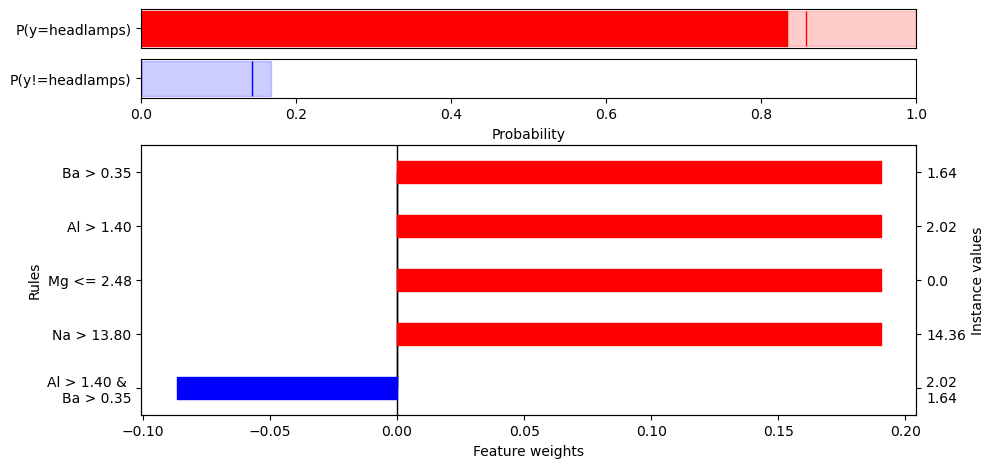

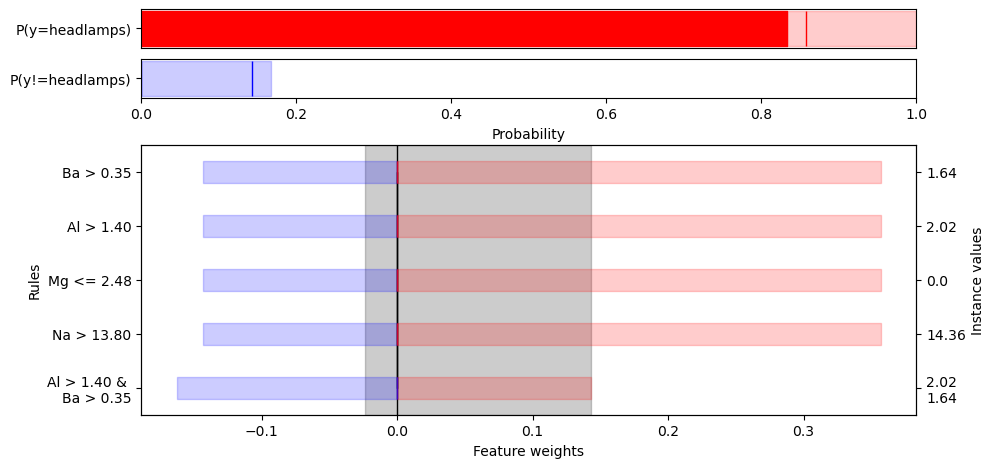

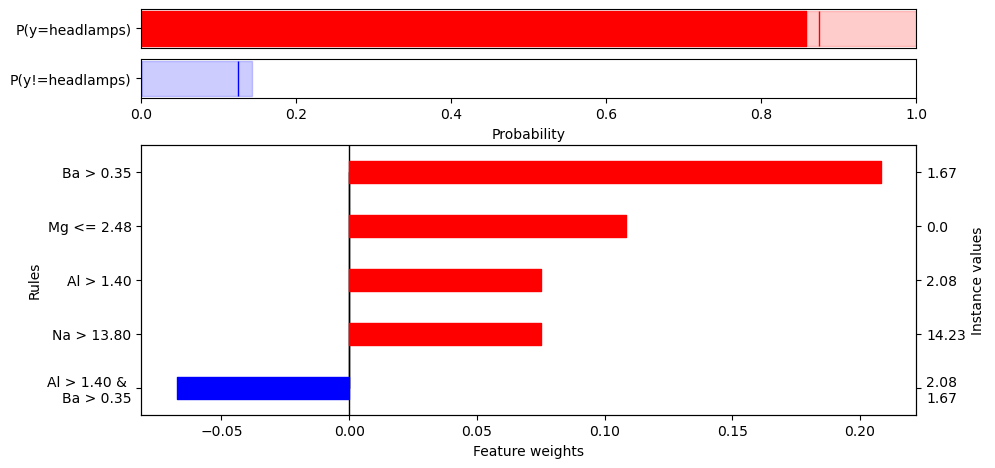

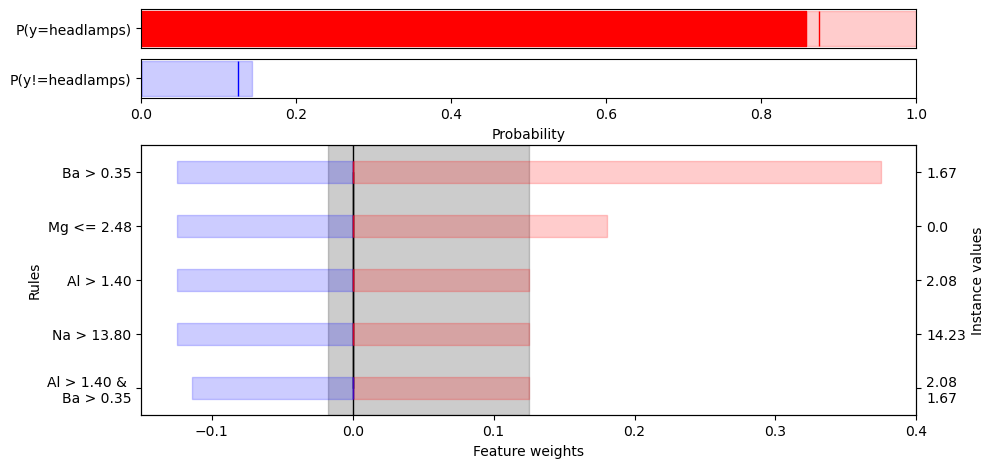

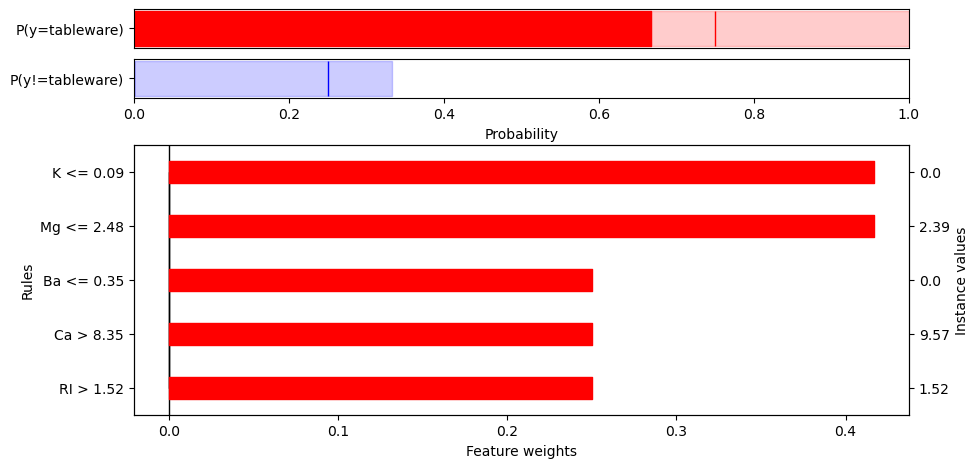

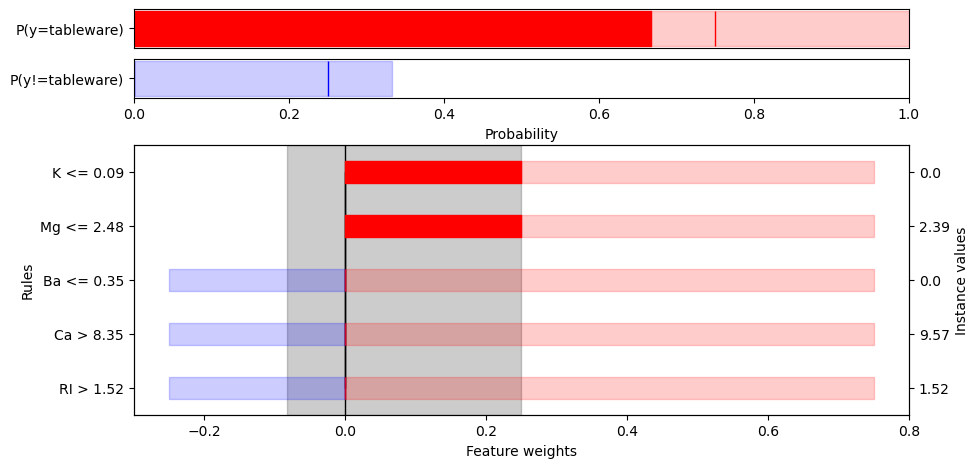

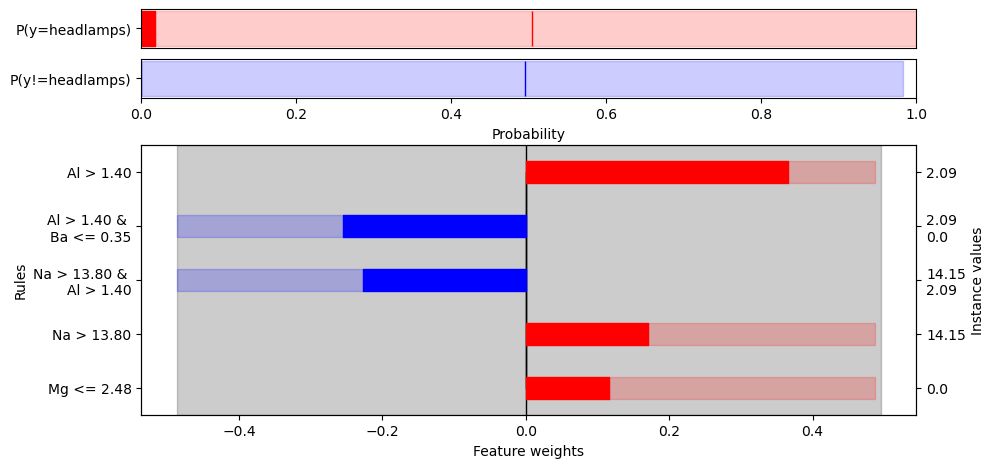

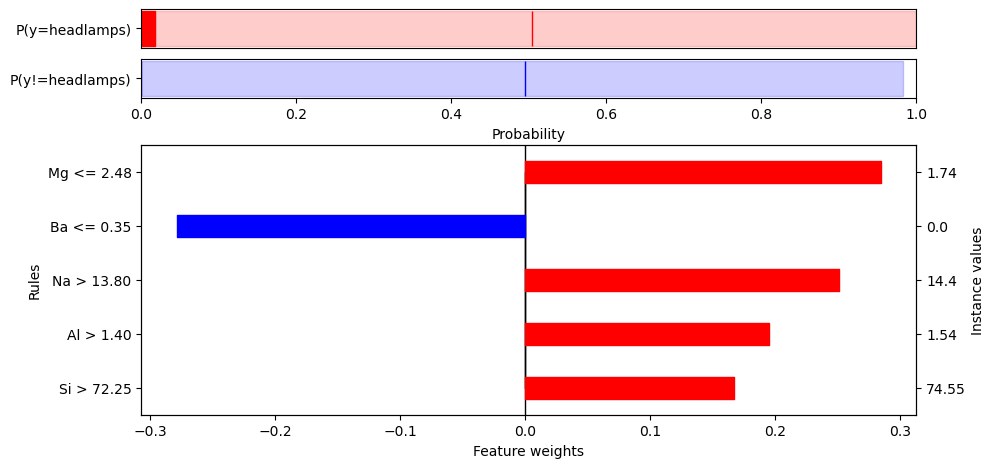

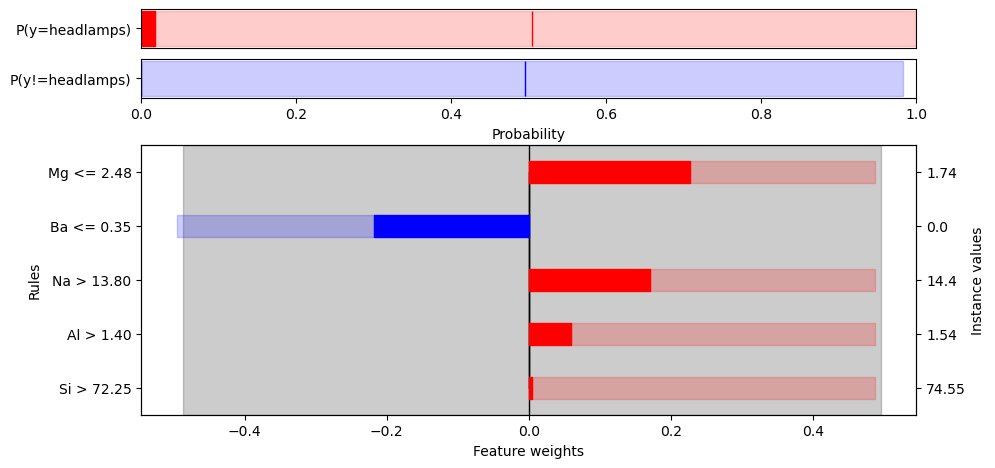

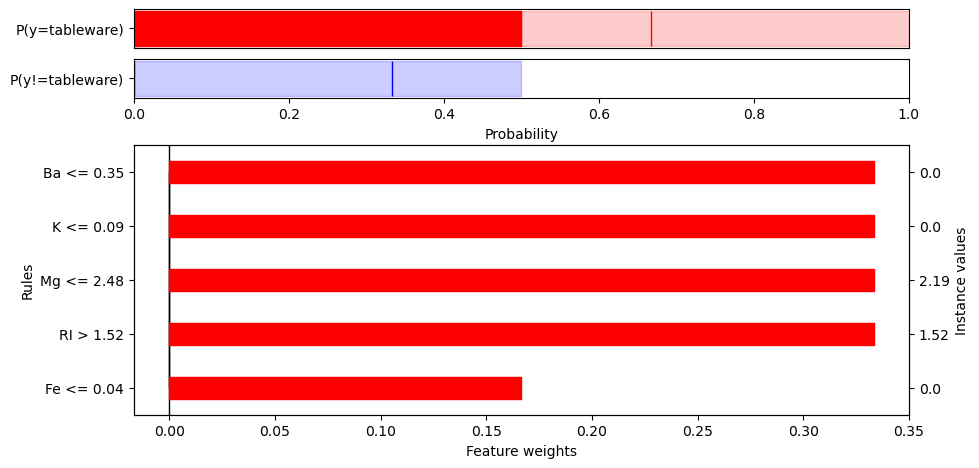

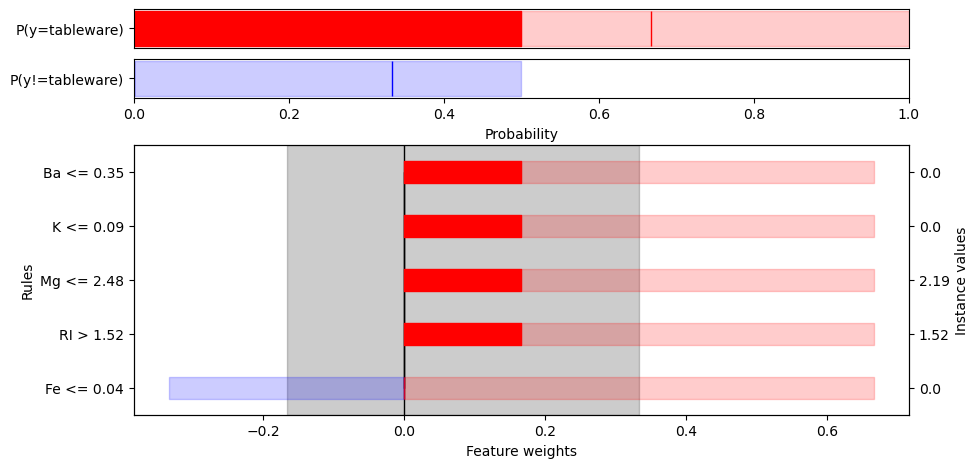

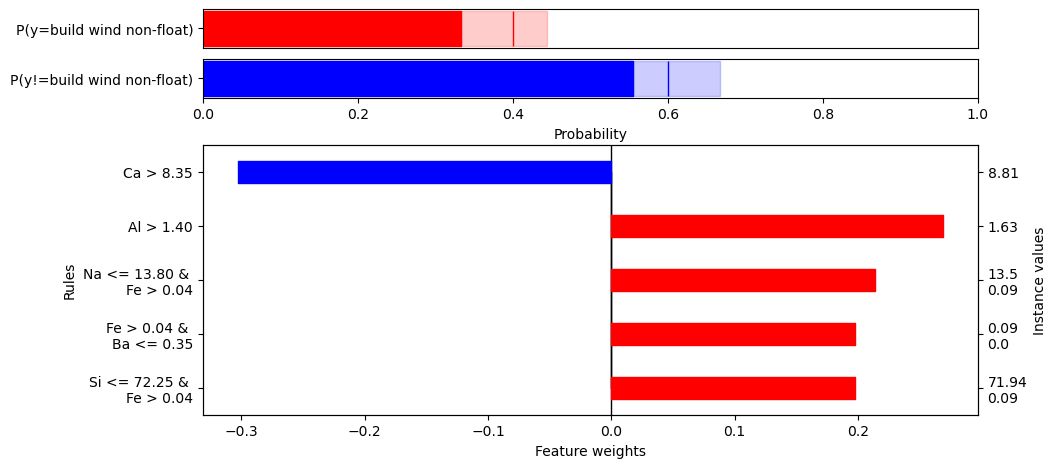

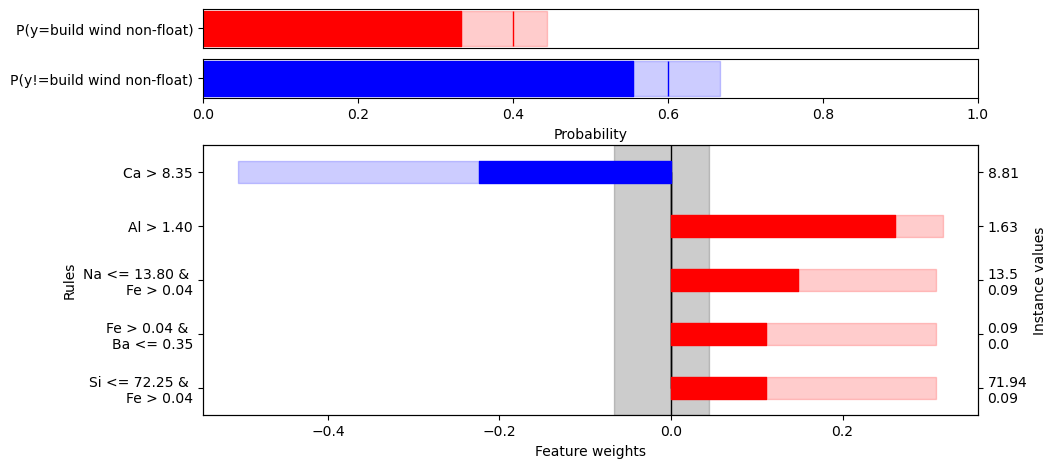

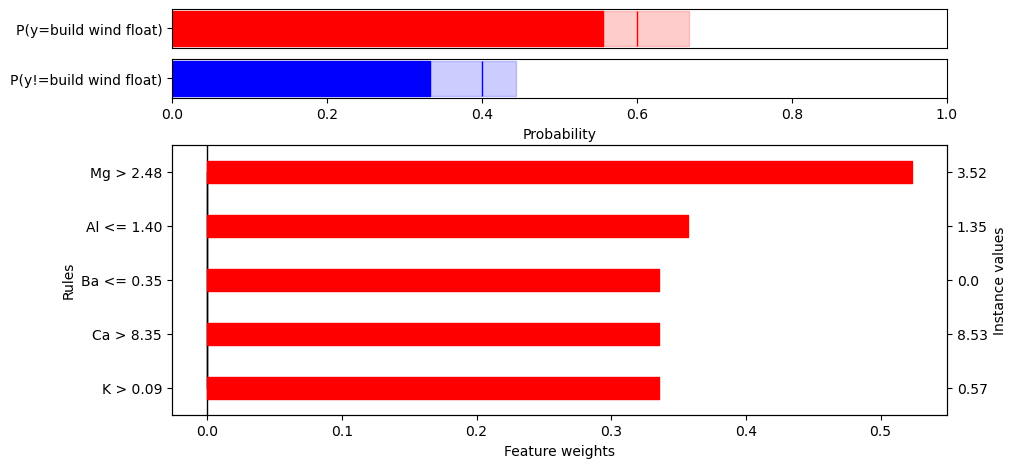

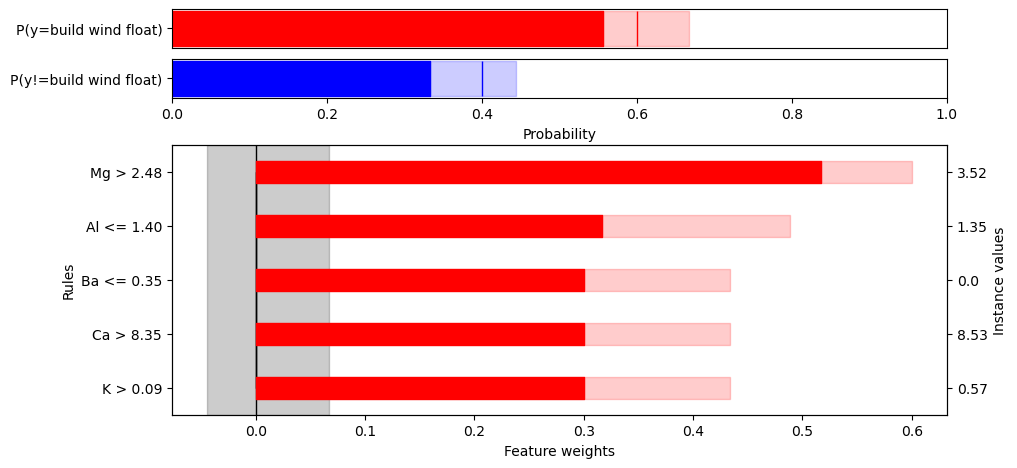

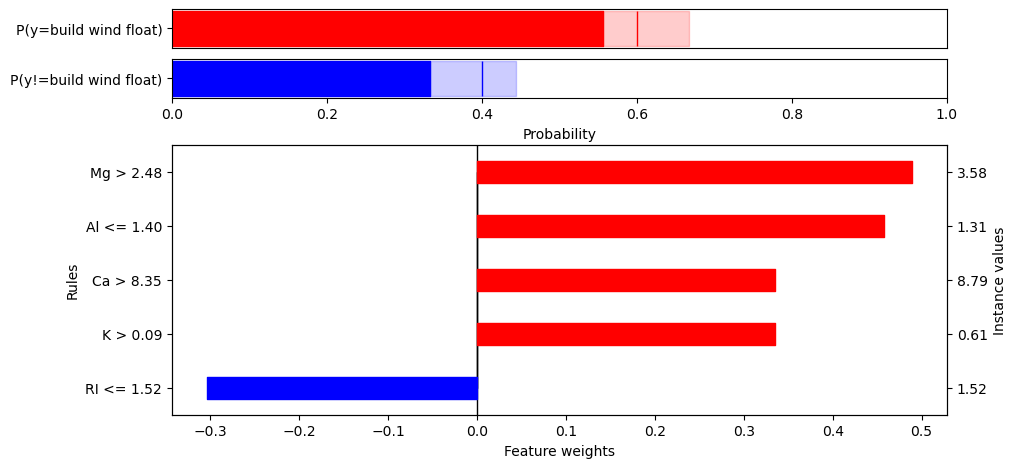

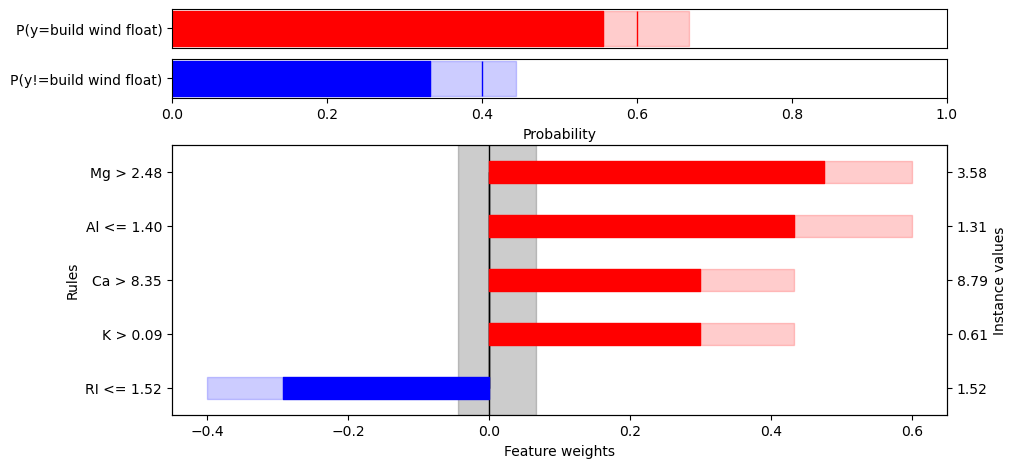

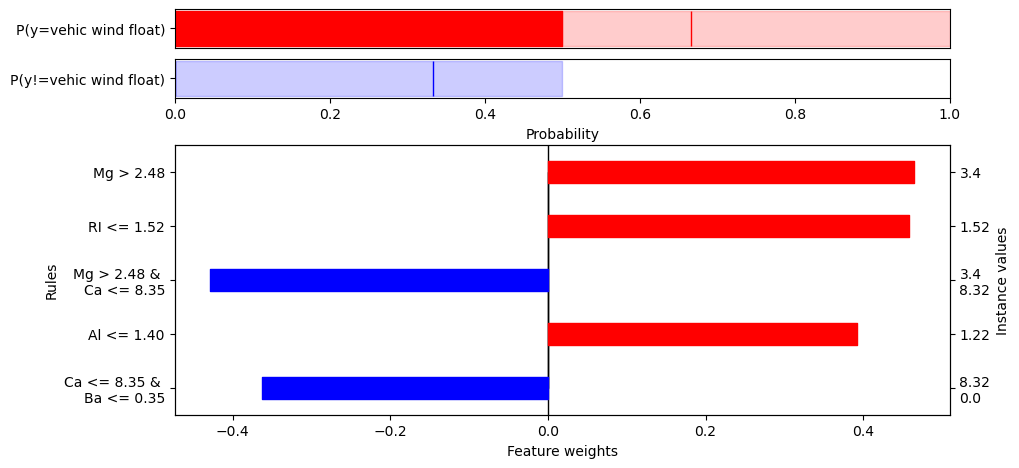

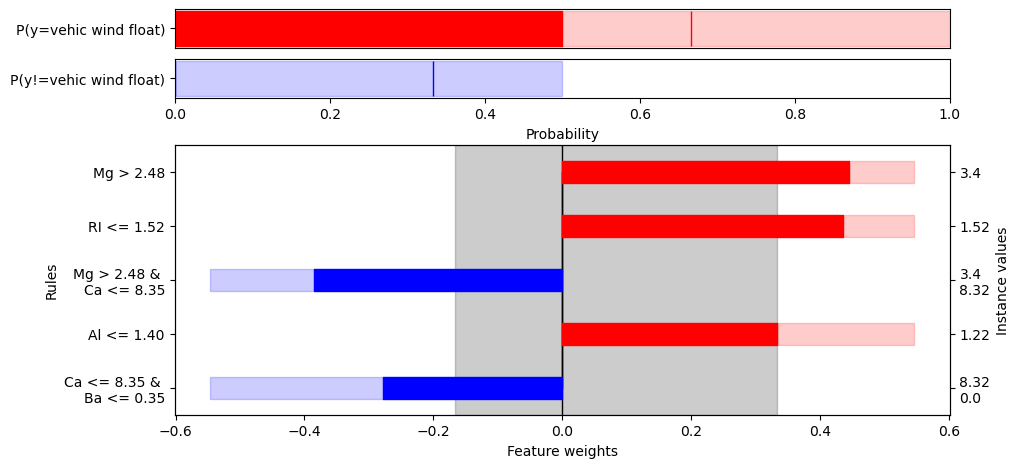

In [12]:
factual_explanations.add_conjunctions()
for i in range(num_to_test):
    explanation = factual_explanations.get_explanation(i)
    explanation.plot(n_features_to_show=5, filename=f'{dataSet}_{i}_c{y_test[i]}_p{predicted_classes[i]}_conjunctive_factual.png')
    explanation.plot(uncertainty=True, n_features_to_show=5, filename=f'{dataSet}_{i}_c{y_test[i]}_p{predicted_classes[i]}_conjunctive_factual_uncertainty.png')

In [13]:
counterfactual_explanations = ce.explain_counterfactual(X_test)

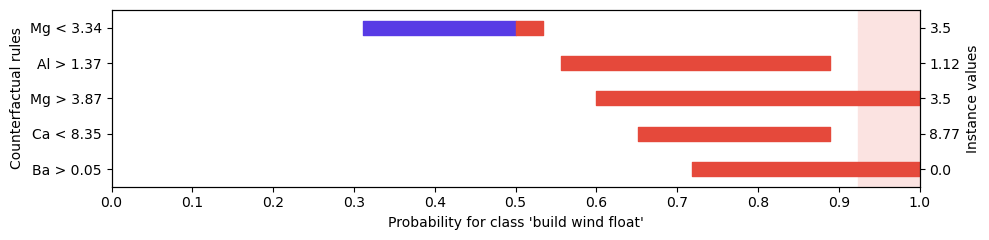

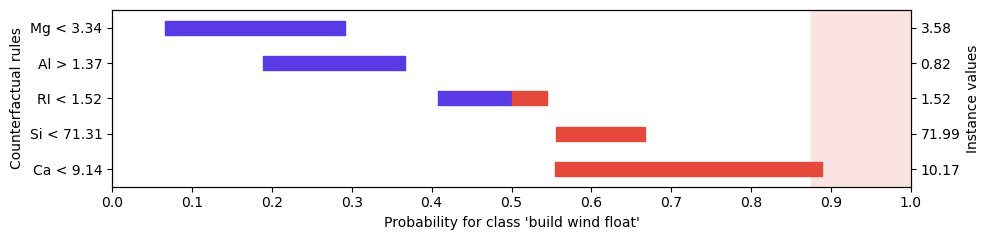

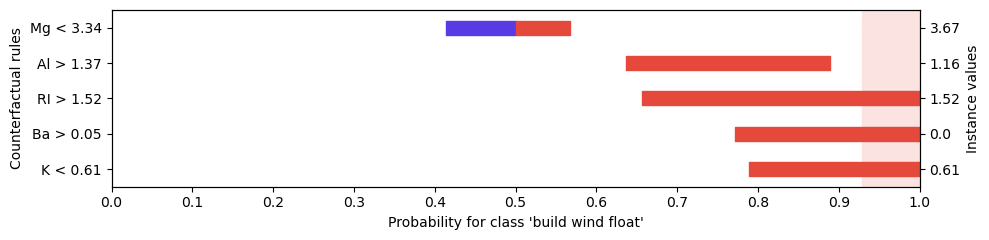

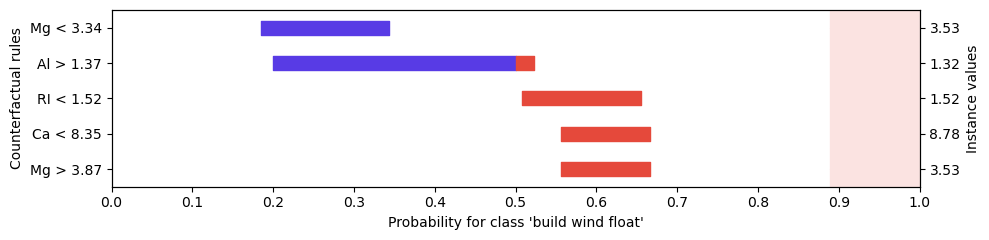

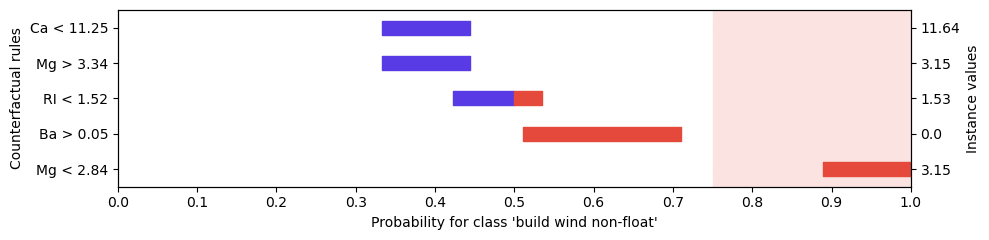

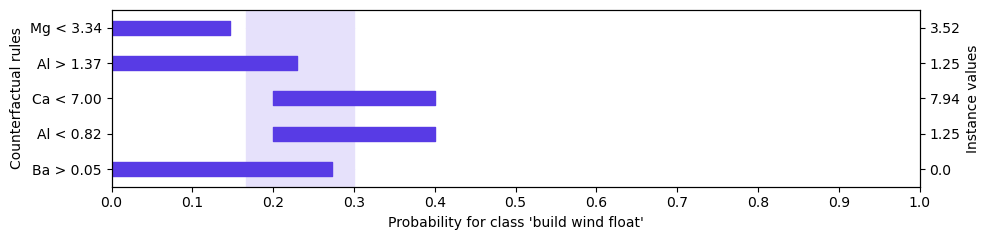

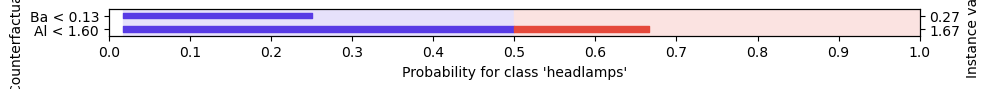

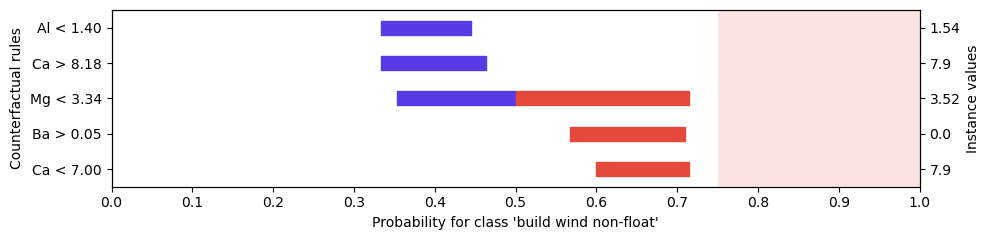

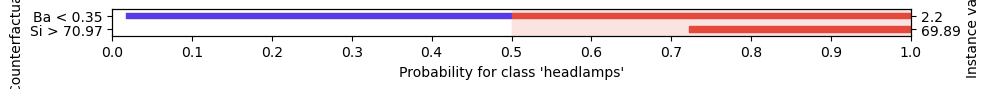

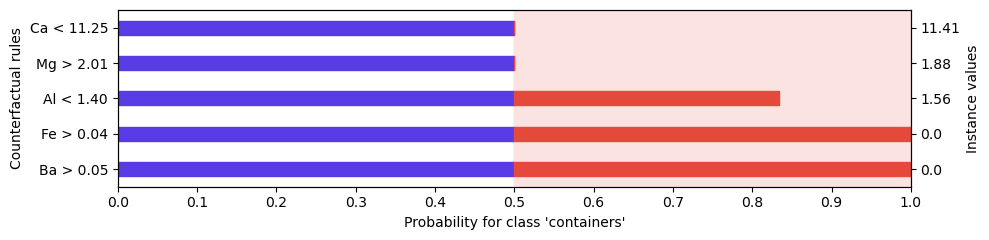

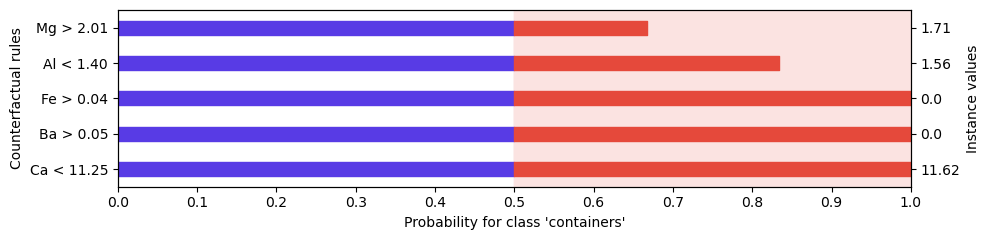

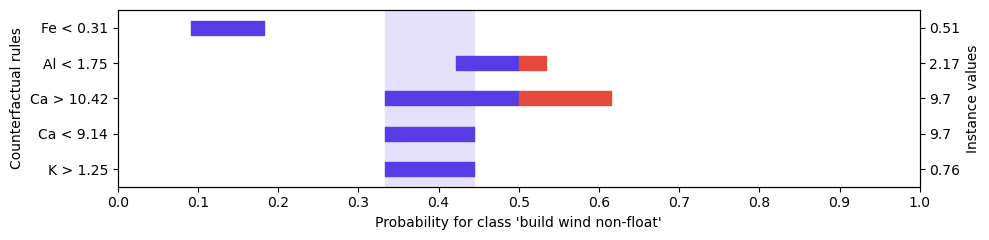

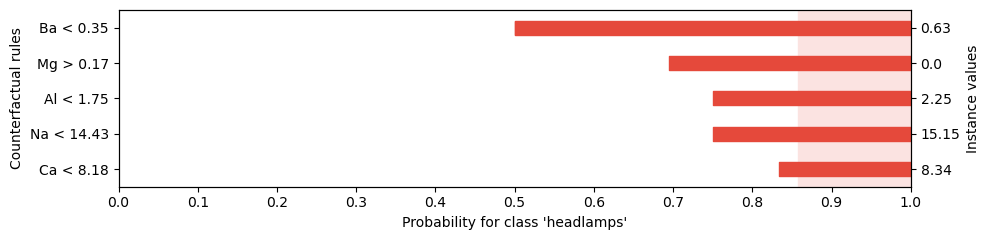

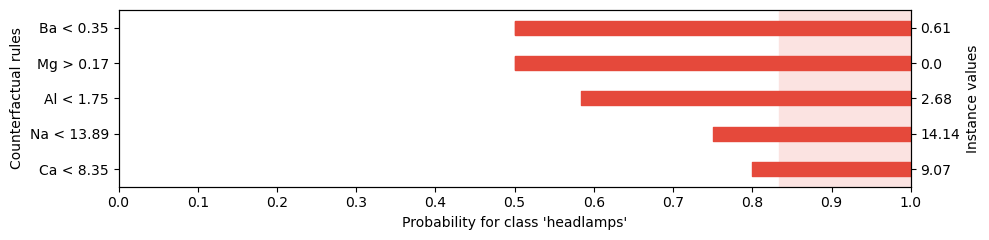

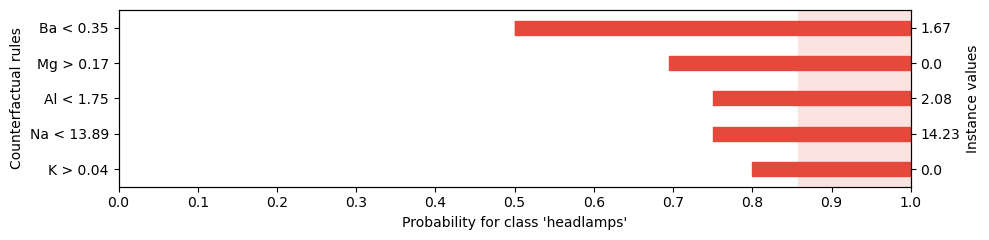

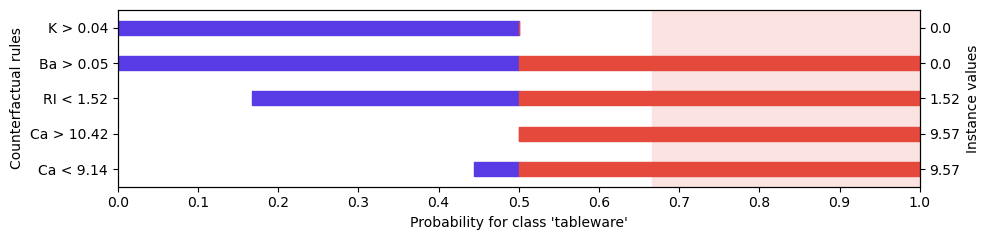

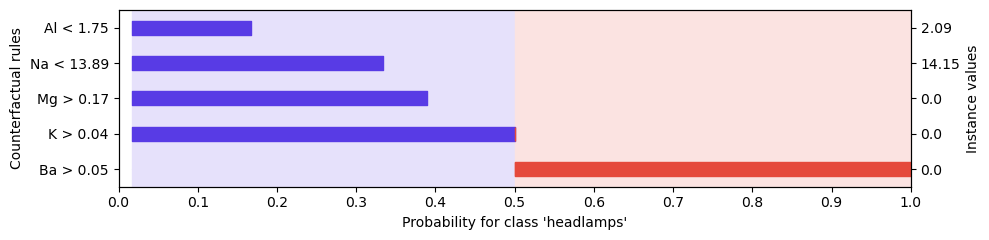

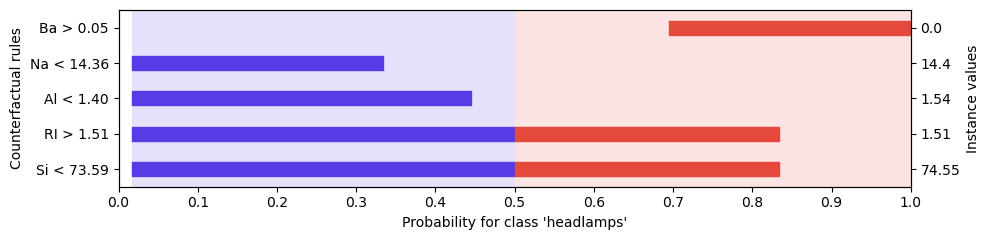

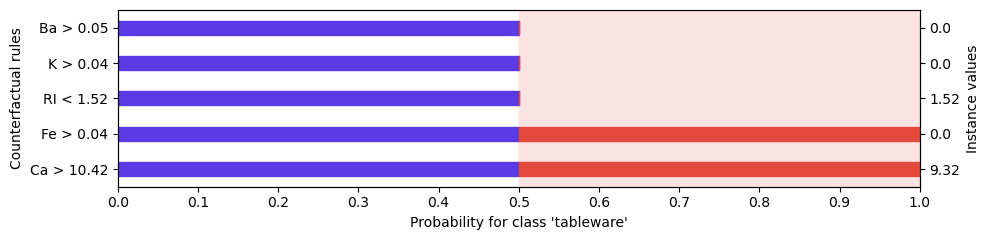

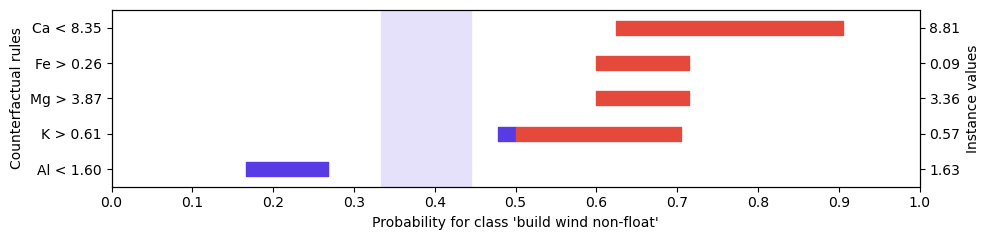

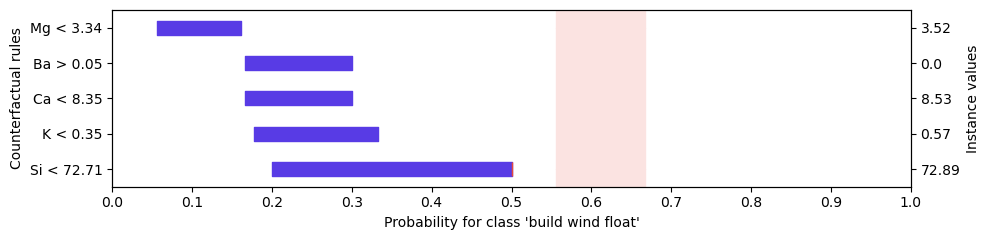

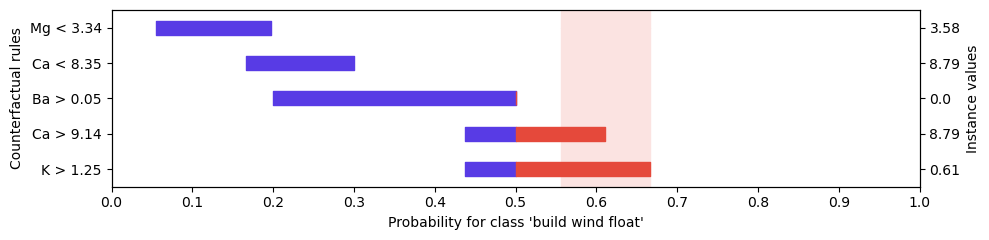

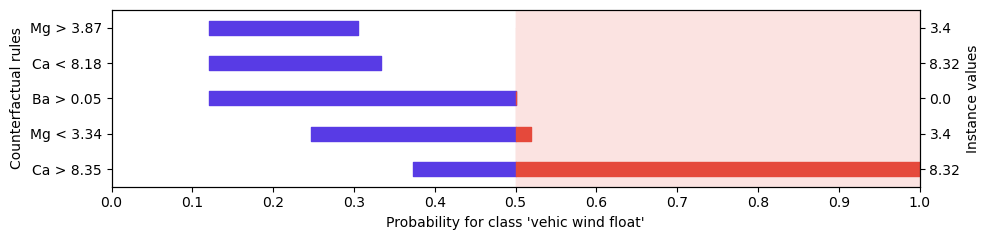

In [14]:
for i in range(num_to_test):
    explanation = counterfactual_explanations.get_explanation(i)
    explanation.plot(n_features_to_show=5, filename=f'{dataSet}_{i}_c{y_test[i]}_p{predicted_classes[i]}_simple_counterfactual.png')

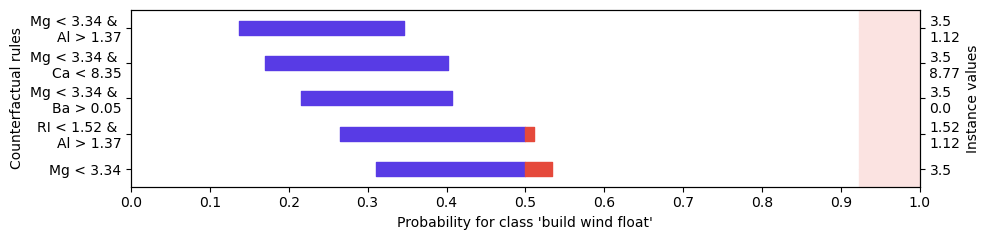

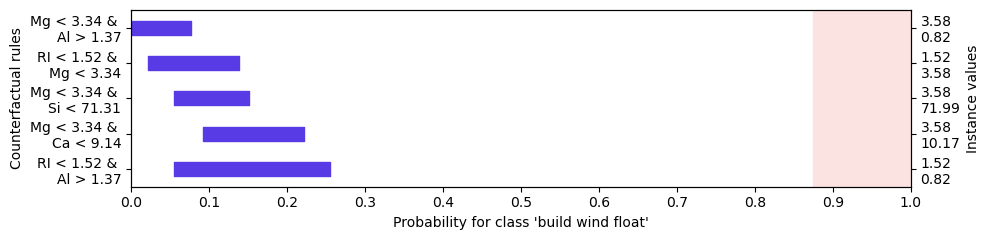

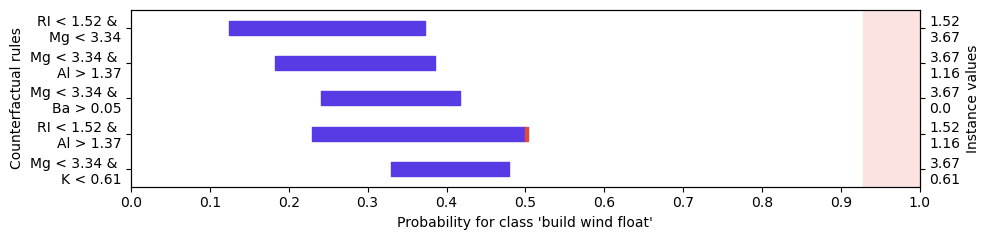

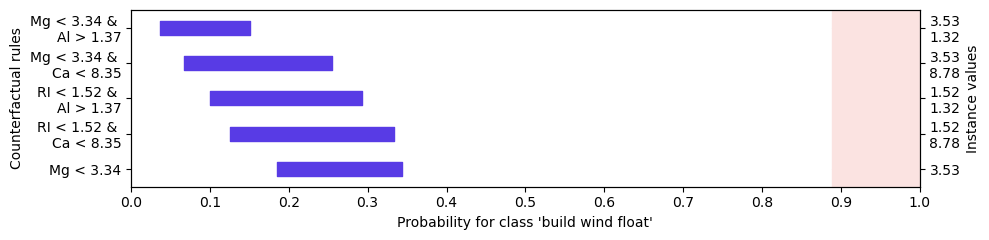

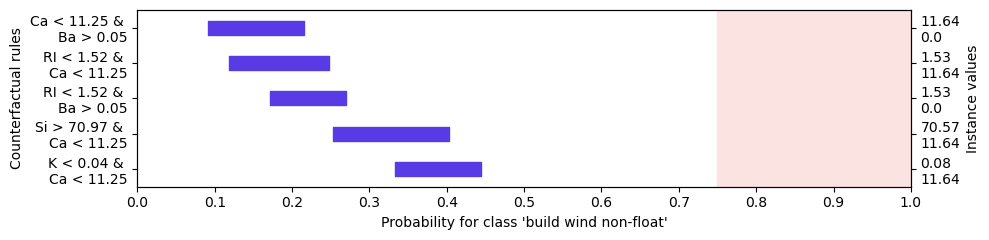

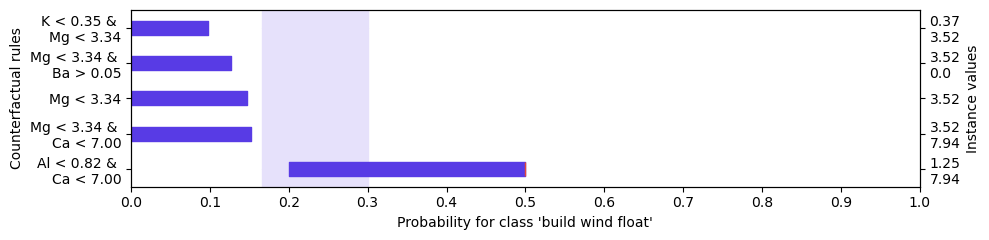

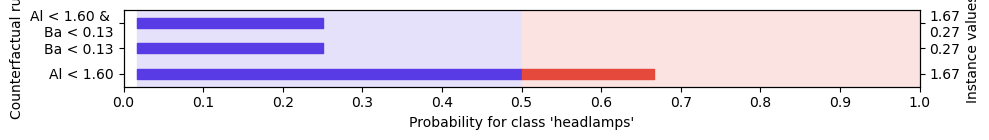

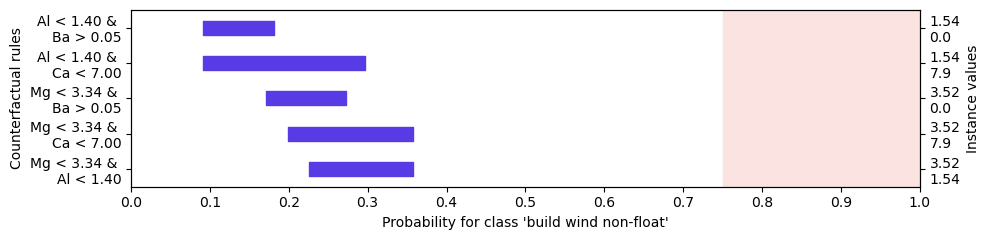

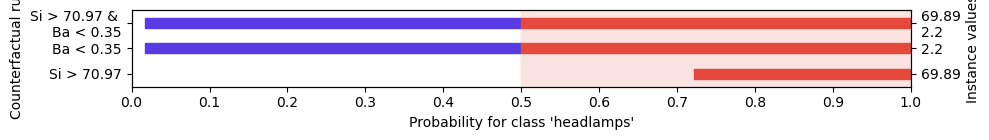

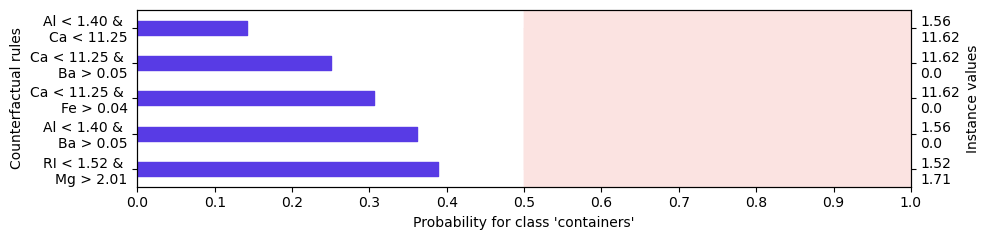

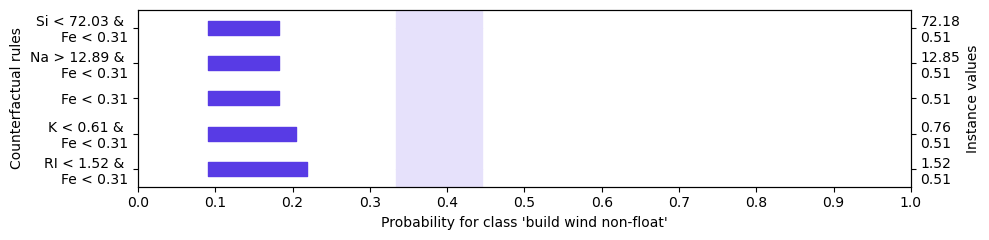

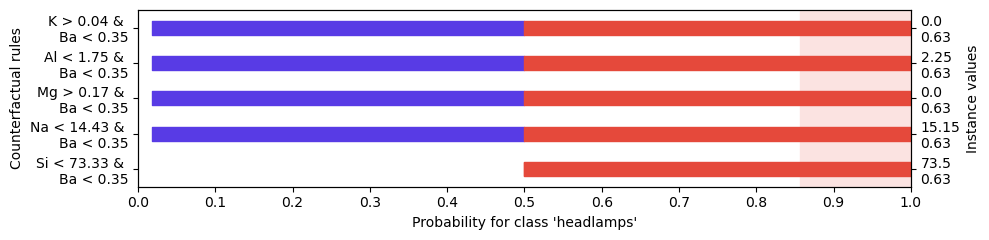

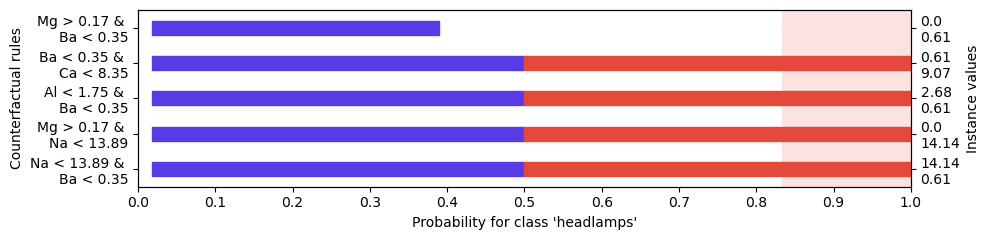

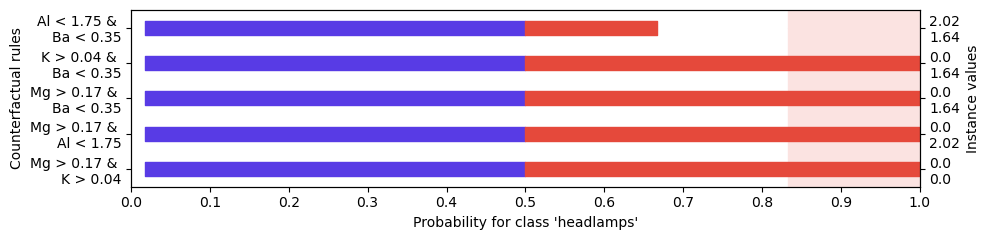

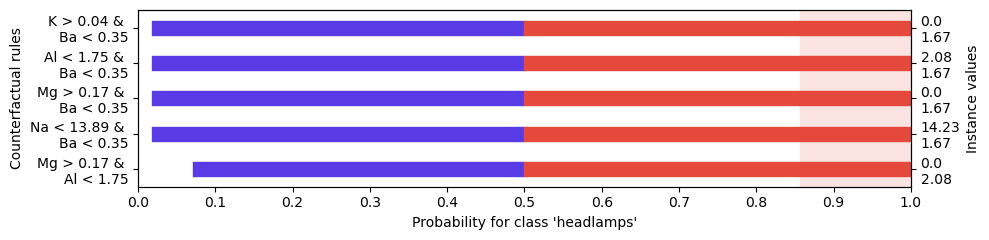

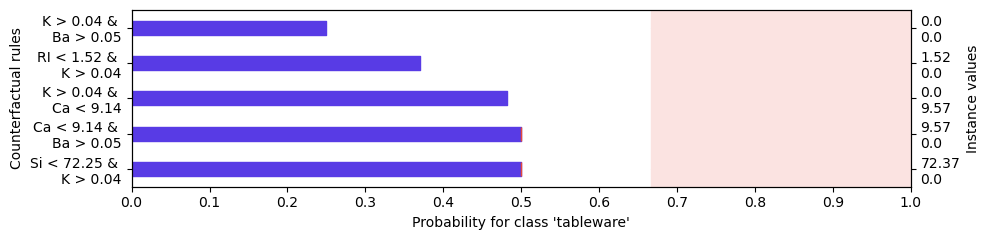

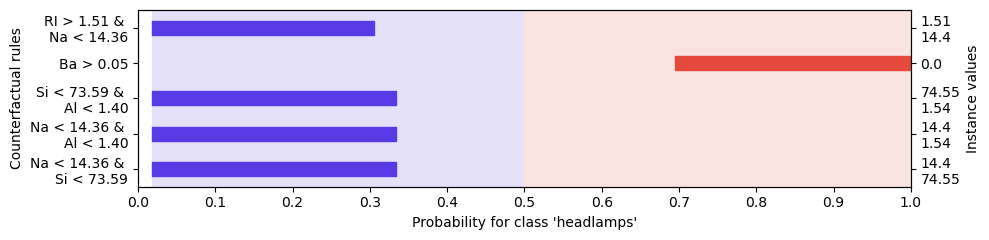

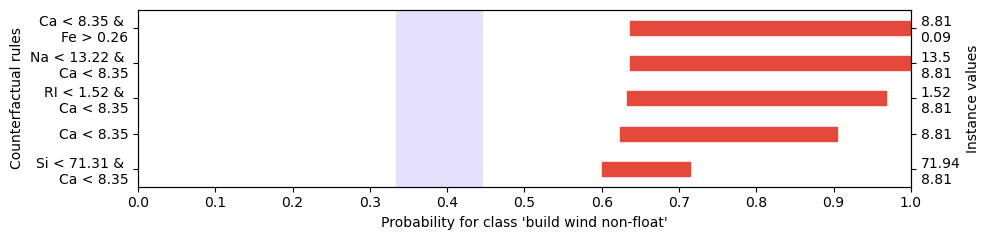

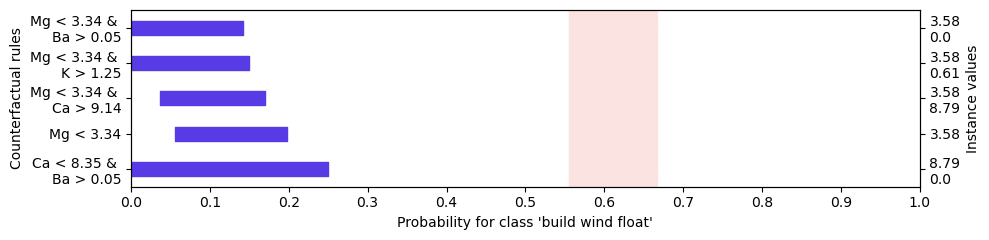

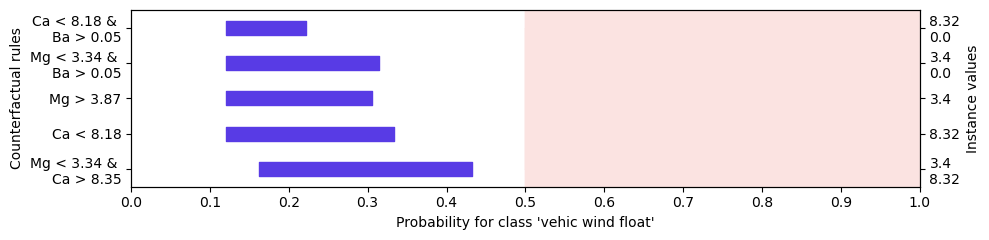

In [15]:
counterfactual_explanations.add_conjunctions()
for i in range(num_to_test):
    explanation = counterfactual_explanations.get_explanation(i)
    explanation.plot(n_features_to_show=5, filename=f'{dataSet}_{i}_c{y_test[i]}_p{predicted_classes[i]}_conjunctive_counterfactual.png')